<a href="https://colab.research.google.com/github/daze0/data-intensive-final-project/blob/master/src/NFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto: NFL Combine

**Programmazione di Applicazioni Data Intensive**<br />
Sviluppato da Leon Baiocchi e Alessandro Zanzi.

In [611]:
# setup e test librerie
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [612]:
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


## 1A) Caso di studio: Draft result prediction
- Dati i risultati del NFL Combine tra gli anni 2009 e 2019, sfrutteremo i dati raccolti sui vari giocatori con l'intento di addestrare il modello migliore in grado di predirre se un giocatore verrà scelto o meno al Draft.
- Da ciascun giocatore si possono estrarre varie caratteristiche:
    - età, peso, velocità sulle 40 yard, max reps benchpress , vertical jump result, ...
- Dal dataset con i risultati del NFL Combine possiamo estrarre ciascuna di queste feature sulla base delle quali il draft avrà esito positivo, e quindi un giocatore sarà "scelto", o negativo.

In [613]:
 !pip install kaggle #decomment if already installed.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [614]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [615]:
!cp kaggle.json ~/.kaggle/

In [616]:
!chmod 600 ~/.kaggle/kaggle.json

- Utilizziamo il dataset [NFL Combine - Performance Data(2009 - 2019)](https://www.kaggle.com/datasets/redlineracer/nfl-combine-performance-data-2009-2019), in cui ogni riga contiene i dati delle performance di un dato giocatore.
- Per importare il dataset è opportuno aver installato `kaggle` e aver settato il proprio token per l'API
- Dopodichè si può passare al download dell'intero dataset in formato `csv`

In [617]:
import os.path
if not os.path.exists('NFL'+'.csv'):
    import kaggle
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('redlineracer/nfl-combine-performance-data-2009-2019', unzip=True)

In [618]:
dataset = pd.read_csv('NFL.csv', index_col=0)

In [619]:
dataset.head(6)

,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Drafted..tm.rnd.yr.,BMI,Player_Type,Position_Type,Position,Drafted
Year,,,,,,,,,,,,,,,,,
2009,Beanie Wells\WellCh00,20.0,Ohio St.,1.8542,106.594207,4.38,85.09,25.0,325.12,NaN,NaN,Arizona Cardinals / 1st / 31st pick / 2009,31.004194,offense,backs_receivers,RB,Yes
2009,Will Davis\DaviWi99,22.0,Illinois,1.8796,118.387609,4.84,83.82,27.0,292.10,7.38,4.45,Arizona Cardinals / 6th / 204th pick / 2009,33.510073,defense,defensive_lineman,DE,Yes
2009,Herman Johnson\JohnHe23,24.0,LSU,2.0066,165.107623,5.50,NaN,21.0,NaN,NaN,NaN,Arizona Cardinals / 5th / 167th pick / 2009,41.005821,offense,offensive_lineman,OG,Yes
2009,Rashad Johnson\JohnRa98,23.0,Alabama,1.8034,92.079251,4.49,93.98,15.0,304.80,7.09,4.23,Arizona Cardinals / 3rd / 95th pick / 2009,28.312463,defense,defensive_back,FS,Yes
2009,Cody Brown\BrowCo96,22.0,Connecticut,1.8796,110.676538,4.76,92.71,26.0,304.80,7.10,4.40,Arizona Cardinals / 2nd / 63rd pick / 2009,31.327425,defense,line_backer,OLB,Yes
2009,Trevor Canfield\CanfTr20,23.0,Cincinnati,1.9304,139.252858,5.28,NaN,29.0,NaN,NaN,NaN,Arizona Cardinals / 7th / 254th pick / 2009,37.368830,offense,offensive_lineman,OG,Yes


### Analisi variabili dataset

- `Year`: anno in cui si è svolto il Combine training, è indice del dataset;
- `Player`: nome/id del giocatore;
- `Age`: età del giocatore;
- `School`: scuola frequentata;
- `Height`: altezza (m);
- `Weight`: peso (Kg);
- `Sprint_40yd`: tempo scatto sulle 40 yard (s);
- `Vertical_Jump`: salto verticale (cm);
- `Bench_Press_Reps`: maggior numero di ripetizioni su panca piana con 102.1 Kg;
- `Broad_Jump`: salto in lungo (cm);
- `Agility_3cone`: tempo migliore percorso a coni (s);
- `Shuttle`: scivolamento laterale (s);
- `Drafted..tm.rnd.yr`: il team che ha scelto il giocatore, a quale round del draft, con quale scelta(in numero) e l'anno del draft;
- `BMI`: Body Mass Index (Kg/m³), indice di massa corporea è un dato biometrico, espresso come rapporto tra peso e quadrato dell'altezza di un individuo ed è utilizzato come un indicatore dello stato di peso forma;
- `Player_Type`: tipo di giocatore(difensivo o offensivo);
- `Position_Type`: classificazione ampia della posizione di gioco degli atleti;
- `Position`: posizione del giocatore;
- `Drafted`: esito del Draft;
<hr />
Come si può notare anche dalla cella qui sotto, il numero di variabili è 17 mentre le istanze totali sono 3477.

In [620]:
dataset.shape

(3477, 17)

- Nell'analisi delle osservazioni ci siamo resi conto che alcune variabili possono essere scartate in quanto <i>non rilevanti</i> al fine di determinare l'esito del Draft.
- Queste variabili sono le seguenti:
    - `Player`, `Age`, `Drafted..tm..rnd.yr`, `Player_Type`, `Position_Type`
- Per quanto riguarda la variabile da predire, la nostra scelta è ricaduta su `Drafted`, una variabile discreta binaria che indica se un giocatore sarà scelto o meno al Draft, in particolare 'Yes' o 'No'.
- Iniziamo quindi a raccogliere le varie feature insieme.

In [621]:
features = [
    "School", "Height", 
    "Weight", "Sprint_40yd",
    "Vertical_Jump", "Bench_Press_Reps", 
    "Broad_Jump", "Agility_3cone",
    "Shuttle", "BMI", "Position"
]

In [622]:
target = "Drafted"

## 1B) Analisi esplorativa dei dati:
- Calcolo numero di giocatori drafted e non-drafted.

In [623]:
dataset["Drafted"].value_counts()

Yes    2254
No     1223
Name: Drafted, dtype: int64

In [624]:
dataset["Drafted"].value_counts(normalize=True)

Yes    0.64826
No     0.35174
Name: Drafted, dtype: float64

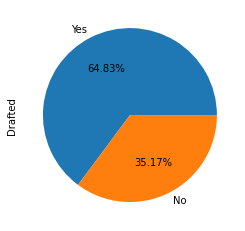

In [625]:
dataset["Drafted"].value_counts().plot.pie(autopct="%.2f%%");

- Analisi dei dati con distribuzioni, medie, stddev, percentili, numero valori distinti delle feature.

In [626]:
dataset.iloc[:, :].describe()

,Age,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,BMI
count,2927.000000,3477.000000,3477.000000,3303.000000,2780.000000,2572.000000,2749.000000,2260.000000,2337.000000,3477.000000
mean,21.983259,1.873968,109.746393,4.769080,83.392403,20.241058,291.629698,7.237416,4.403843,31.074417
std,0.969490,0.067494,20.483780,0.301477,10.678403,6.497600,23.960879,0.410230,0.265224,4.438279
min,18.000000,1.651000,67.585263,4.220000,44.450000,2.000000,198.120000,6.280000,3.810000,21.609798
25%,21.000000,1.828800,92.986436,4.530000,76.200000,15.000000,276.860000,6.940000,4.200000,27.475641
50%,22.000000,1.879600,104.779837,4.690000,83.820000,20.000000,294.640000,7.140000,4.360000,30.122626
75%,23.000000,1.930400,125.645087,4.960000,90.170000,25.000000,307.340000,7.490000,4.560000,34.038647
max,28.000000,2.082800,167.375585,6.000000,114.300000,49.000000,373.380000,9.040000,5.560000,44.680097


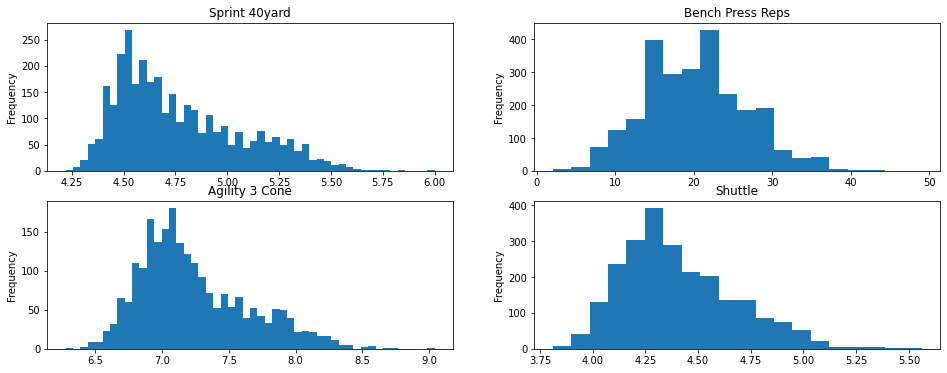

In [627]:
plt.figure(figsize=(16, 6))
dataset["Sprint_40yd"].plot.hist(bins=50, ax=plt.subplot(2, 2, 1), title="Sprint 40yard");
dataset["Bench_Press_Reps"].plot.hist(bins=20, ax=plt.subplot(2, 2, 2), title="Bench Press Reps");
dataset["Agility_3cone"].plot.hist(bins=50, ax=plt.subplot(2, 2, 3), title="Agility 3 Cone");
dataset["Shuttle"].plot.hist(bins=20, ax=plt.subplot(2, 2, 4), title="Shuttle");

### Distribuzione valori suddivisi per classi

- In un problema di classificazione, è utile visualizzare quanto le variabili predittive siano correlate con la classe da predire
- Negli ultimi punti dell'esercizio abbiamo generato grafici con la distribuzione delle variabili, senza distinzioni tra giocatori *Draftati* e non
- Vogliamo ora integrare l'informazione `Drafted` negli stessi grafici, per valutare quanto le variabili siano utili nella predizione dell'esito del Draft.

- Attraverso un'istogramma _stacked_ di `BMI`, in cui in ogni intervallo si vede la suddivisione tra atleti **Drafted** e **Non-drafted**
  - con `pivot(columns="Drafted")` suddividiamo ciascuna colonna nel frame, suddividendo i valori relativi all'esitto del *Draft*
  - con `["BMI"]` selezioniamo le varie colonne
  - visualizzandole in un'istogramma, specificando `stacked=True` per far sì che le barre delle colonne siano poste una sopra l'altra

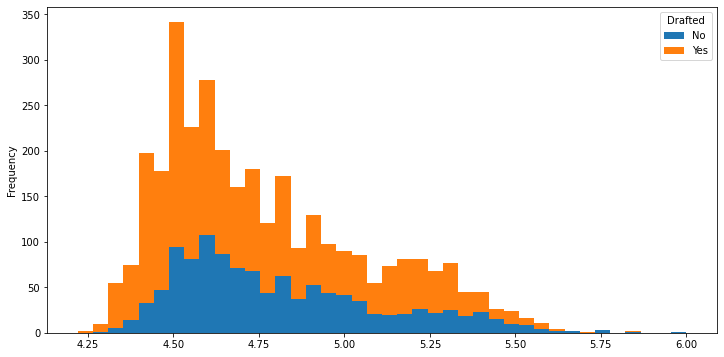

In [628]:
dataset_by_player = pd.read_csv('NFL.csv', index_col=1)
dataset_by_player.pivot_table(index="Player", columns="Drafted", values="Sprint_40yd").plot.hist(bins=40, stacked=True, figsize=(12, 6));

- Questo grafico evidenzia ad es. che i *giocatori* con tempo sulle 40 yard minore di `4.75s` sono più propensi ad essere **scelti** al Draft.

- Possiamo evidenziare le classi anche nei diagrammi a dispersione con la distribuzione tra due variabili, differenziando i punti ad es. per colore
- Definiamo in un dizionario che associ un colore a ciascuna classe

In [629]:
drafted_color_map = {"Yes": "blue", "No": "red"}

- Col metodo `map`, convertiamo ciascun elemento in una serie (o frame) secondo un dizionario dato

In [630]:
drafted_colors = dataset_by_player["Drafted"].map(drafted_color_map)

- Otteniamo così una serie di valori che cotiene tutti i colori sopre indicati.

In [631]:
drafted_colors.tail(10)

Player
Devon Johnson               red
Tytus Howard                red
Chauncey Gardner-Johnson    red
Ashton Dulin                red
Keelan Doss                 red
Xavier Crawford             red
Jordan Brown                red
Corey Ballentine            red
Ugo Amadi                   red
Nasir Adderley              red
Name: Drafted, dtype: object

- Usiamo questa serie come parametro `c` nel metodo `plot.scatter` per assegnare un colore differenziato ai punti del grafico a dispersione

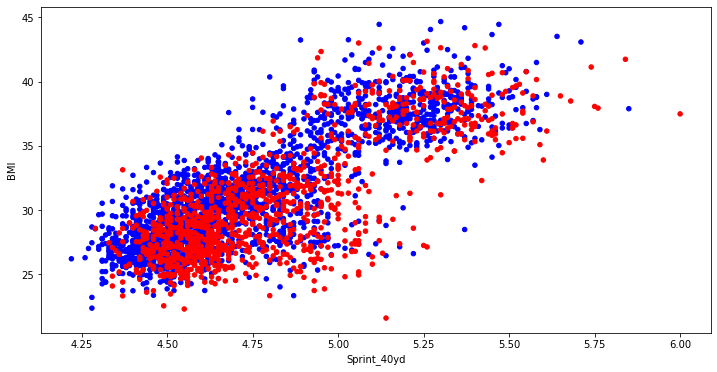

In [632]:
dataset_by_player.plot.scatter("Sprint_40yd", "BMI", c=drafted_colors, figsize=(12, 6));

#### Correlazione tra <code>Position</code>, <code>Position_Type</code>, <code>Player_Type</code>
Le seguenti *variabili* sono correlate tra loro, infatti abbiamo che: 
- <code>Position</code> corrisponde ad una **posizione specifica** di un *giocatore*, essa è poi dipendente da <code>Position_Type</code> che rappresenta la **tipologia di posizione**, dove ognuna *comprende* un determinato *insieme di posizioni specifiche*.
- A sua volta poi, ogni tipologia è relativa ad un determinato <code>Player_Type</code> che indica il **tipo di giocatore**, ad esempio difensore(*defense*) o attaccante(*offense*).

In [633]:
dataset["Position"]

Year
2009     RB
2009     DE
2009     OG
2009     FS
2009    OLB
       ... 
2019     CB
2019     CB
2019     CB
2019      S
2019      S
Name: Position, Length: 3477, dtype: object

In [634]:
dataset["Position_Type"]

Year
2009      backs_receivers
2009    defensive_lineman
2009    offensive_lineman
2009       defensive_back
2009          line_backer
              ...        
2019       defensive_back
2019       defensive_back
2019       defensive_back
2019       defensive_back
2019       defensive_back
Name: Position_Type, Length: 3477, dtype: object

In [635]:
dataset["Player_Type"]

Year
2009    offense
2009    defense
2009    offense
2009    defense
2009    defense
         ...   
2019    defense
2019    defense
2019    defense
2019    defense
2019    defense
Name: Player_Type, Length: 3477, dtype: object

In [636]:
positions_by_pos_type = {}
for pos_type in dataset["Position_Type"].value_counts().index:
  players_by_pos_type = dataset[dataset["Position_Type"] == pos_type]
  positions_by_pos_type[pos_type] = players_by_pos_type["Position"].value_counts().index.to_list()
positions_by_pos_type

{'backs_receivers': ['WR', 'RB', 'QB', 'TE', 'FB'],
 'defensive_back': ['CB', 'SS', 'FS', 'S', 'DB'],
 'offensive_lineman': ['OT', 'OG', 'C'],
 'defensive_lineman': ['DT', 'DE'],
 'line_backer': ['OLB', 'ILB'],
 'kicking_specialist': ['P', 'K'],
 'other_special': ['LS']}

In [637]:
pos_type_by_player_type = {}
for player_type in dataset["Player_Type"].value_counts().index:
  players_by_player_type = dataset[dataset["Player_Type"] == player_type]
  pos_type_by_player_type[player_type] = players_by_player_type["Position_Type"].value_counts().index.to_list()
pos_type_by_player_type

{'offense': ['backs_receivers', 'offensive_lineman'],
 'defense': ['defensive_back', 'defensive_lineman', 'line_backer'],
 'special_teams': ['kicking_specialist', 'other_special']}

#### Analisi *prove* più indicative per ciascun `Position_Type` 
Sarebbe interessante vedere quali *prove* sono più indicative per una determinata `Position`; questo si può verificare facilmente sfruttando i `Position_Type` dei giocatori, verificando quali gruppi hanno performance migliori in determinate *prove*(attraverso l'analisi di grafici).<br/>
Così facendo potremmo capire se un determinato **gioctore** ha risultati sufficenti nelle *prove* che contano maggiormente per la sua `Position`.<br/>
Es: un `WR` che corre le *40yard* con un tempo maggiore di 4.8s non ha molte chance; al contrario un `OLB` che ottiene un tempo inferiore a 4.8s sulle 40yard aumenta le sue possibilità di essere *draftato*.

In [638]:
dataset["Position_Type"].value_counts()

backs_receivers       1260
defensive_back         657
offensive_lineman      555
defensive_lineman      501
line_backer            380
kicking_specialist     111
other_special           13
Name: Position_Type, dtype: int64

- Attraverso un'istogramma _stacked_ di `BMI`, in cui in ogni intervallo si vede la suddivisione dei valori tra i vari `Position_Type`
  - con `pivot(columns="Position_Type")` suddividiamo ciascuna colonna nel frame, suddividendo i valori relativi ai vari *gruppi*
  - con `["BMI"]` selezioniamo le varie colonne
  - visualizzandole in un'istogramma, specificando `stacked=True` per far sì che le barre delle colonne siano poste una sopra l'altra

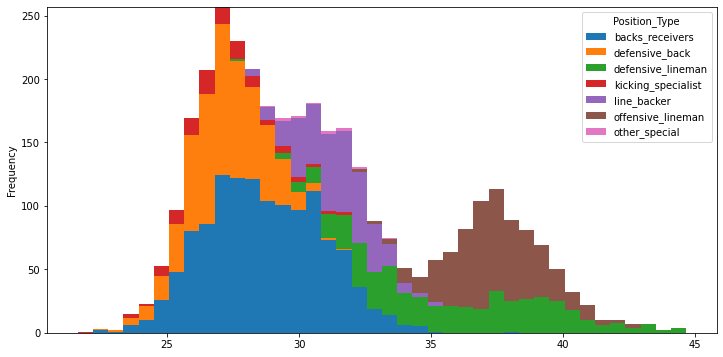

In [639]:
dataset_by_player = pd.read_csv('NFL.csv', index_col=1)
dataset_by_player.pivot(columns="Position_Type")["BMI"].plot.hist(bins=40, stacked=True, figsize=(12, 6));

- Questo grafico evidenzia ad es. che l'indice `BMI` è tendenzialmente più alto negli `offensive_lineman` e `defensive_lineman`, mentre è simile per i restanti gruppi.

- Possiamo evidenziare le classi anche nei diagrammi a dispersione con la distribuzione tra due variabili, differenziando i punti ad es. per colore
- Definiamo in un dizionario che associ un colore a ciascuna classe:

In [640]:
BMI_color_map = {"backs_receivers": "blue", "defensive_back": "orange", "defensive_lineman": "green", "kicking_specialist": "red",\
                 "line_backer": "purple", "offensive_lineman": "brown", "other_special": "pink"}

- Col metodo `map`, convertiamo ciascun elemento in una serie (o frame) secondo un dizionario dato:

In [641]:
BMI_colors = dataset_by_player["Position_Type"].map(BMI_color_map)

- Otteniamo così una serie di valori che cotiene tutti i colori sopre indicati.

In [642]:
BMI_colors.tail(10)

Player
Devon Johnson                brown
Tytus Howard                 brown
Chauncey Gardner-Johnson    orange
Ashton Dulin                  blue
Keelan Doss                   blue
Xavier Crawford             orange
Jordan Brown                orange
Corey Ballentine            orange
Ugo Amadi                   orange
Nasir Adderley              orange
Name: Position_Type, dtype: object

- Usiamo questa serie come parametro `c` nel metodo `plot.scatter` per assegnare un colore differenziato ai punti del grafico a dispersione

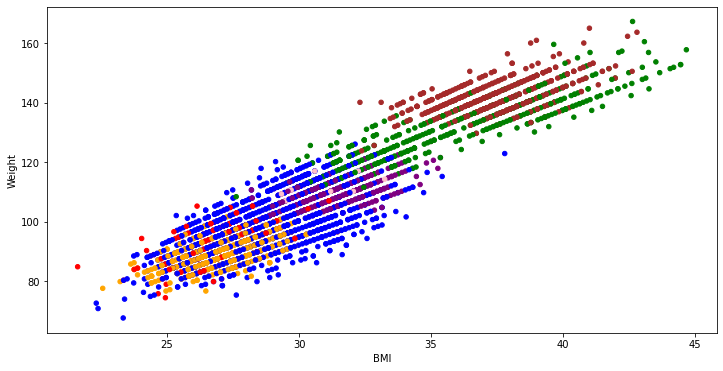

In [643]:
dataset_by_player.plot.scatter("BMI", "Weight", c=BMI_colors, figsize=(12, 6));

-Ora prendiamo in considerazione ciascun `Position_Type`analizzando i *grafici* relativi alle varie *prove*; così facendo si può notare quali sono le *prove* maggiormente rilevanti per una determinata `Position`.

- Attraferso la *funzione* `position_groups` è possibile selezionare, mediante il suo nome, uno specifico **gruppo**, del quale verrano mostrati il numero di **giocatori** per ciascuna `Position`, e i grafici relativi a ciascuna *prova* relativi al `Position_Type` selezionato.

In [644]:
def position_groups(pos):
  players = dataset[dataset["Position_Type"] == pos]
  for n, col in enumerate(["Sprint_40yd", "Bench_Press_Reps", "Agility_3cone", "Shuttle", "Vertical_Jump", "Broad_Jump"], start=1):
      players[col].plot.hist(bins=40, ax=plt.subplot(2, 3, n), figsize=(18, 8), title=col);
  return players["Position"].value_counts();

WR    506
RB    320
QB    194
TE    191
FB     49
Name: Position, dtype: int64

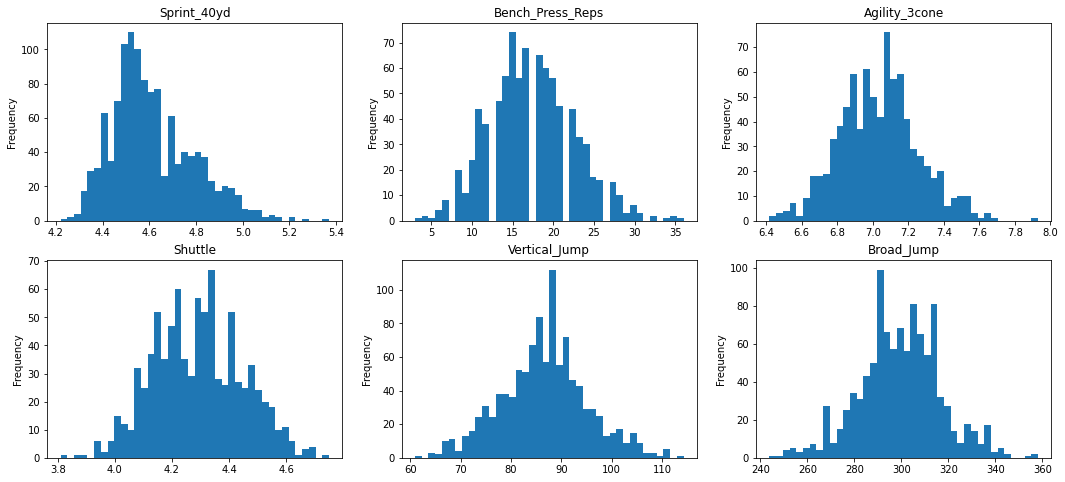

In [645]:
position_groups("backs_receivers")

- Per il *gruppo* dei `back_recivers` possiamo notare ottimi risultati nelle seguenti *prove*: `Sprint_40yd`, `Agility_3cone`, `Vertical_Jump` e `Broad_Jump`.

CB    393
SS    108
FS     98
S      56
DB      2
Name: Position, dtype: int64

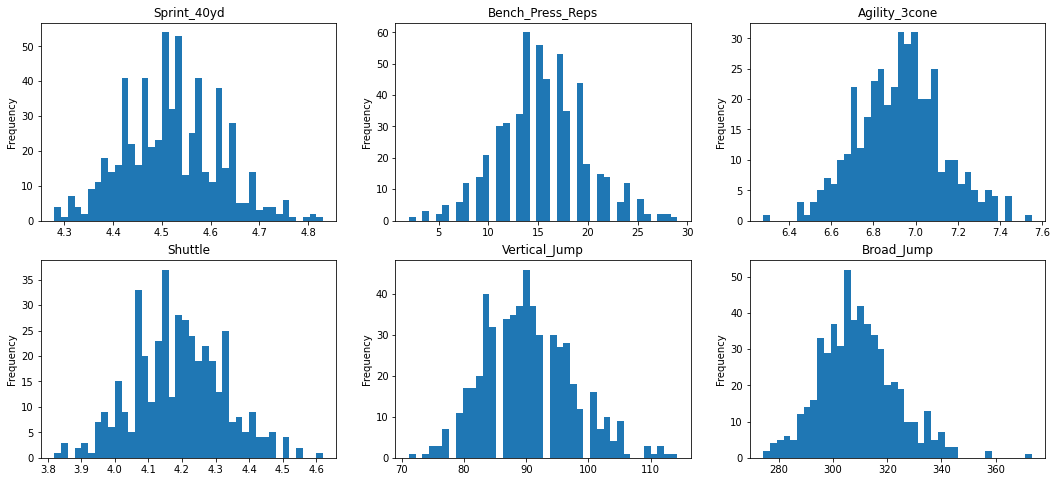

In [646]:
position_groups("defensive_back")

- Per il *gruppo* dei `defensive_back` possiamo notare ottimi risultati nelle seguenti *prove*: `Sprint_40yd`, `Agility_3cone`, `Shuttle`, `Vertical_Jump` e `Broad_Jump`.
- Ad una prima analisi approssimativa questo sembra essere il `Position_Group` più atletico.

OLB    232
ILB    148
Name: Position, dtype: int64

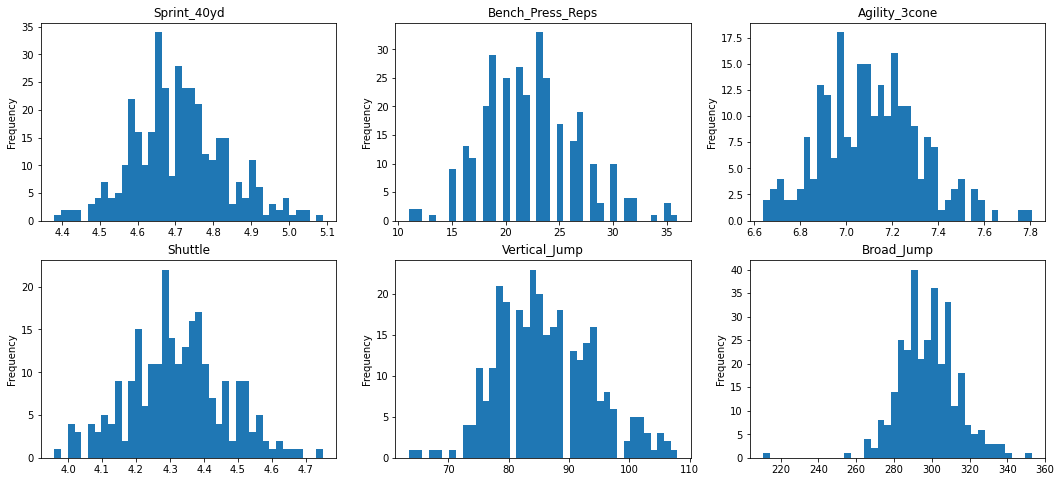

In [647]:
position_groups("line_backer")

- Per il *gruppo* dei `line_backer` possiamo notare ottimi risultati nelle seguenti *prove*: `Shuttle`,  `Vertical_Jump`e `Broad_Jump`.

### Scelta delle features
- Nella selezione delle feature, dopo un confronto, abbiamo stabilito quali variabili potessero essere utili ai fini della classificazione e quali no.
- Di seguito vengono riportate le variabili da noi scartate con le opportune motivazioni.
- Consideriamo quindi le features, da noi prese in considerazione, all'interno di `features, lista precedentemente definita.
- Creiamo un'altra lista `not_features` con al proprio interno tutti i nomi relativi alle variabili che non vengono considerate features.

In [648]:
not_features = [x for x in dataset.columns.to_list() if x not in features and x != "Drafted"]
features_data = dataset.drop(columns=not_features)
features_data

,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,BMI,Position,Drafted
Year,,,,,,,,,,,,
2009,Ohio St.,1.8542,106.594207,4.38,85.09,25.0,325.12,NaN,NaN,31.004194,RB,Yes
2009,Illinois,1.8796,118.387609,4.84,83.82,27.0,292.10,7.38,4.45,33.510073,DE,Yes
2009,LSU,2.0066,165.107623,5.50,NaN,21.0,NaN,NaN,NaN,41.005821,OG,Yes
2009,Alabama,1.8034,92.079251,4.49,93.98,15.0,304.80,7.09,4.23,28.312463,FS,Yes
2009,Connecticut,1.8796,110.676538,4.76,92.71,26.0,304.80,7.10,4.40,31.327425,OLB,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
2019,Central Michigan,1.8034,84.821773,4.48,95.25,11.0,NaN,NaN,NaN,26.080939,CB,No
2019,South Dakota St.,1.8288,91.172066,4.51,100.33,13.0,325.12,NaN,NaN,27.260221,CB,No
2019,Washburn,1.8034,88.904105,4.47,100.33,15.0,342.90,6.82,4.14,27.336171,CB,No


- Esploriamo i dati:

In [649]:
for col in range(len(features_data.columns.to_list())-1):
    separator = "----------------------------------\n"
    print(separator + f'{features_data.columns.to_list()[col].upper()}\n')
    print(features_data.iloc[:, col].value_counts())
    

----------------------------------
SCHOOL

Alabama                   101
LSU                        95
Ohio St.                   82
USC                        79
Florida                    76
                         ... 
North Carolina Central      1
Hobart & William Smith      1
NW State (LA)               1
Navy                        1
Washburn                    1
Name: School, Length: 253, dtype: int64
----------------------------------
HEIGHT

1.9050    480
1.8542    435
1.8796    432
1.8288    410
1.9304    408
1.9558    337
1.8034    311
1.7780    219
1.9812    159
1.7526    129
2.0066     65
1.7272     45
1.7018     20
2.0320     19
1.6764      5
1.6510      1
2.0574      1
2.0828      1
Name: Height, dtype: int64
----------------------------------
WEIGHT

95.707990     54
92.986436     48
90.264882     47
88.450512     46
96.615175     46
              ..
159.664514     1
165.107623     1
74.842741      1
73.935556      1
72.574779      1
Name: Weight, Length: 194, dtype: i

- Creiamo ora un'altro `DataFrame` con solo i dati relativi alle `not_features`, esclusa la colonna `Drafted`:

In [650]:
not_features_data = dataset.drop(columns=features).drop(columns='Drafted')
not_features_data

,Player,Age,Drafted..tm.rnd.yr.,Player_Type,Position_Type
Year,,,,,
2009,Beanie Wells\WellCh00,20.0,Arizona Cardinals / 1st / 31st pick / 2009,offense,backs_receivers
2009,Will Davis\DaviWi99,22.0,Arizona Cardinals / 6th / 204th pick / 2009,defense,defensive_lineman
2009,Herman Johnson\JohnHe23,24.0,Arizona Cardinals / 5th / 167th pick / 2009,offense,offensive_lineman
2009,Rashad Johnson\JohnRa98,23.0,Arizona Cardinals / 3rd / 95th pick / 2009,defense,defensive_back
2009,Cody Brown\BrowCo96,22.0,Arizona Cardinals / 2nd / 63rd pick / 2009,defense,line_backer
...,...,...,...,...,...
2019,Xavier Crawford,NaN,NaN,defense,defensive_back
2019,Jordan Brown,NaN,NaN,defense,defensive_back
2019,Corey Ballentine,NaN,NaN,defense,defensive_back


- Questa volta includiamo anche `Drafted` per ulteriori analisi:

In [651]:
not_features_data_with_drafted = dataset.drop(columns=features)
not_features_data_with_drafted

,Player,Age,Drafted..tm.rnd.yr.,Player_Type,Position_Type,Drafted
Year,,,,,,
2009,Beanie Wells\WellCh00,20.0,Arizona Cardinals / 1st / 31st pick / 2009,offense,backs_receivers,Yes
2009,Will Davis\DaviWi99,22.0,Arizona Cardinals / 6th / 204th pick / 2009,defense,defensive_lineman,Yes
2009,Herman Johnson\JohnHe23,24.0,Arizona Cardinals / 5th / 167th pick / 2009,offense,offensive_lineman,Yes
2009,Rashad Johnson\JohnRa98,23.0,Arizona Cardinals / 3rd / 95th pick / 2009,defense,defensive_back,Yes
2009,Cody Brown\BrowCo96,22.0,Arizona Cardinals / 2nd / 63rd pick / 2009,defense,line_backer,Yes
...,...,...,...,...,...,...
2019,Xavier Crawford,NaN,NaN,defense,defensive_back,No
2019,Jordan Brown,NaN,NaN,defense,defensive_back,No
2019,Corey Ballentine,NaN,NaN,defense,defensive_back,No


- Le variabili non necessarie sono le seguenti:
    - <code>Player</code>
    - <code>Age</code>
    - <code>Drafted..tm.rnd.yr</code>
    - <code>Position_Type</code>, <code>Player_Type</code>
- Nella parte sottostante vengono spiegate le varie ragioni che ci hanno portato a non scegliere queste variabili per la nostra classificazione, fatta eccezione per `Position_Type` e `Player_Type` che sono strettamente correlate a `Position` come visto nel sotto-paragrafo precedente.


#### Player
Per quanto riguarda l'attributo Player abbiamo deciso di scartarlo in quanto il nome di un giocatore non influisce sulla probabilità di essere sclelto al Draft, questo almeno in un sistema equo come si ipotizza che quello del Combine sia.


In [652]:
not_features_data["Player"]

Year
2009      Beanie Wells\WellCh00
2009        Will Davis\DaviWi99
2009    Herman Johnson\JohnHe23
2009    Rashad Johnson\JohnRa98
2009        Cody Brown\BrowCo96
                 ...           
2019            Xavier Crawford
2019               Jordan Brown
2019           Corey Ballentine
2019                  Ugo Amadi
2019             Nasir Adderley
Name: Player, Length: 3477, dtype: object

In [653]:
not_features_data["Player"].describe()

count            3477
unique           3476
top       Chris Jones
freq                2
Name: Player, dtype: object

#### Age
In egual maniera, anche <code>Age</code> si è mostrata inutile alla ricerca dell'esito di draft dei giocatori, vediamo perchè..

In [654]:
not_features_data["Age"]

Year
2009    20.0
2009    22.0
2009    24.0
2009    23.0
2009    22.0
        ... 
2019     NaN
2019     NaN
2019     NaN
2019     NaN
2019     NaN
Name: Age, Length: 3477, dtype: float64

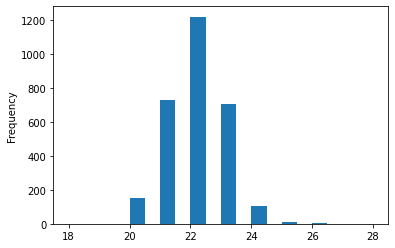

In [655]:
not_features_data["Age"].plot.hist(bins=20);

- In primo luogo, notiamo come alcuni dati siano **mancanti**, con valore <code>NaN</code>.
- I valori mancanti di <code>Age</code> sono <i>550</i> contro i <i>3477</i> totali, per cui riguardano il 16% circa delle osservazioni totali.
- Inoltre si nota che la maggior parte dei giocatori è di età compresa tra i 20 ed i 24 anni.
- Infine, il numero di giocatori di 22 anni supera quello di qualsiasi altra fascia di età.

In [656]:
not_features_data[not_features_data["Age"].isnull()]

,Player,Age,Drafted..tm.rnd.yr.,Player_Type,Position_Type
Year,,,,,
2009,Marcus Freeman,NaN,Chicago Bears / 5th / 154th pick / 2009,defense,line_backer
2009,Terrance Taylor,NaN,Indianapolis Colts / 4th / 136th pick / 2009,defense,defensive_lineman
2009,Demetrius Byrd,NaN,San Diego Chargers / 7th / 224th pick / 2009,offense,backs_receivers
2009,Stryker Sulak,NaN,Oakland Raiders / 6th / 199th pick / 2009,defense,defensive_lineman
2010,Kyle Calloway,NaN,Buffalo Bills / 7th / 216th pick / 2010,offense,offensive_lineman
...,...,...,...,...,...
2019,Xavier Crawford,NaN,NaN,defense,defensive_back
2019,Jordan Brown,NaN,NaN,defense,defensive_back
2019,Corey Ballentine,NaN,NaN,defense,defensive_back


In [657]:
drafted_players = not_features_data[not_features_data["Drafted..tm.rnd.yr."].notna()]
drafted_players.describe()

,Age
count,2243.000000
mean,21.908605
std,0.969256
min,19.000000
25%,21.000000
50%,22.000000
75%,23.000000
max,28.000000


- Si nota dal *DataFrame* nella cella soprastante che i giocatori hanno età(<code>Age</code>) comprese tra i 19 ed i 28 anni.
- L'età media si aggira intorno ai 22 anni.
- Naturalmente questi dati si riflettono anche nell'istogramma visto in precedenza.

##### Cambio di programma - Age in realtà è una feature
- Durante l'analisi delle *variabili* da noi considerate inizialmente <code>not_features</code>, e quindi non utili a determinare se un giocatore sarà draftato o meno, in particolare durante l'analisi di <code>Age</code>, abbiamo osservato come in realtà l'età ha un ruolo importante nell'*esito* del Draft.
- Nelle celle sottostanti vi è il procedimento secondo il quale siamo arrivati a questa conclusione:

In [658]:
def draft_results_by_age(age):
  players = not_features_data[not_features_data["Age"] == age]
  return pd.Series(np.where(players["Drafted..tm.rnd.yr."].notna(), "drafted", "non-drafted")).value_counts(normalize=True)

In [659]:
draft_results_by_age(20)

drafted        0.926667
non-drafted    0.073333
dtype: float64

In [660]:

draft_results_by_age(21)

drafted        0.824176
non-drafted    0.175824
dtype: float64

In [661]:
draft_results_by_age(22)

drafted        0.76601
non-drafted    0.23399
dtype: float64

In [662]:
draft_results_by_age(23)

drafted        0.69078
non-drafted    0.30922
dtype: float64

- Mano a mano che l'età si alza si nota un decremento della percentuale di giocatori **drafted**.
- Andiamo quindi a visualizzare in un grafico l'andamento di questa percentuale in base alle età. <br />Per farlo è necessario estrapolare la percentuale di **drafted** per ogni età e graficare il risultato tramite la libreria <code>matplotlib</code>.

In [663]:
draft_results_by_age(24).to_numpy()[0] # Ritorna la percentuale di drafted relativa ad una determinata età

0.6699029126213593

In [664]:
def populate_drafted_percentages(ages):
  drafted_percentages = []
  for age in ages:
      drafted_percentages.append(draft_results_by_age(age).to_numpy()[0])
  return drafted_percentages

In [665]:
ages = [age for age in range(int(drafted_players["Age"].min()), int(drafted_players["Age"].max() + 1))]
ages

[19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

In [666]:
drafted_percentages = populate_drafted_percentages(ages)
drafted_percentages

[1.0,
 0.9266666666666666,
 0.8241758241758241,
 0.7660098522167488,
 0.6907801418439716,
 0.6699029126213593,
 0.6666666666666666,
 0.5714285714285714,
 1.0,
 1.0]

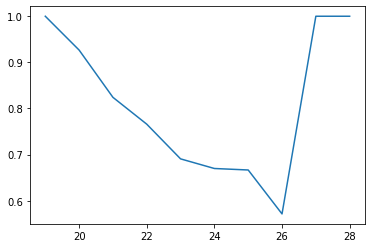

In [667]:
plt.plot(ages, drafted_percentages);

- Il grafico risultante ci mostra come la percentuale di giocatori **drafted** *decresca* con l'*aumentare* dell'**età**, ma solo fino a 26 anni.
- Il modo in cui il l'andamento risalga così repentinamente superata questa soglia è *sospetto*, potrebbe significare che il **rapporto** tra il numero di *giocatori* di età **maggiore** a 26 anni ed il *numero di giocatori totale* sia **molto basso**.
- Verifichiamolo:

In [668]:
(not_features_data["Age"] > 26).value_counts()

False    3475
True        2
Name: Age, dtype: int64

In [669]:
(not_features_data["Age"] > 27).value_counts()

False    3476
True        1
Name: Age, dtype: int64

- Vediamo intanto che vi è un solo *giocatore drafted* sia nell'insieme dei giocatori di 27 anni, che in quello dei 28enni.

In [670]:
(not_features_data["Age"] > 26).value_counts()[True] / not_features_data["Age"].count() 

0.0006832934745473181

In [671]:
(not_features_data["Age"] <= 26).value_counts()[True] / not_features_data["Age"].count()

0.9993167065254527

- La nostra ipotesi era corretta in quanto è stata confermata dal calcolo dei rapporti soprastanti.
- Sorge però un altro dubbio, ci sono altre fascie d'età scarsamente popolate che non abbiamo considerato? La risposta è sì.

In [672]:
(not_features_data["Age"] == 19).value_counts()[True] / not_features_data["Age"].count()

0.00034164673727365904

In [673]:
(not_features_data["Age"] > 24).value_counts()[True] / not_features_data["Age"].count()

0.00717458148274684

Il seguente grafico permette di analizzare l'andamento della percentuale di *giocatori* **drafted** sul totale relativo ad ogni **età**, dove le *fascie di età scarsamente popolate* **non** vengono considerate.

In [674]:
populated_ages = ages[1:-4]
drafted_percentages = populate_drafted_percentages(populated_ages)

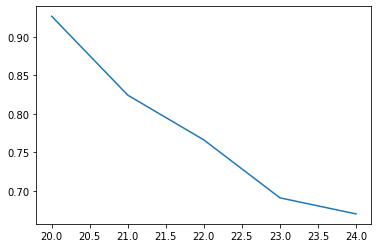

In [675]:
plt.plot(populated_ages, drafted_percentages);

#### Drafted..tm.rnd.yr.
Abbiamo deciso di *scartare* questa variabile in quanto renderebbe il modello di predizione troppo semplice(o troppo difficile, poichè potrebbe voler dire predirre questa variabile piuttosto che `Drafted`), osserviamo perchè:
- In tutte le *osservazioni* in cui <code>Drafted</code> è <code>Yes</code> si nota come questo attributo sia descrittivo della **squadra** che ha ingaggiato il giocatore, il **round** del Combine in cui esso è stato scelto e l'**anno** del draft.
- Al contrario, coloro che *non* vengono draftati ovviamente *non* disporranno di queste informazioni e quindi all'interno del dataset in questi casi si trovano valori <code>NaN</code>.
- Date le circostanze si può affermare che <code>Drafted..tm.rnd.yr.</code> sia completamente dipendente da <code>Drafted</code> e per questo viene *scartata*, difatti renderebbe il modello di predizione *troppo semplice* poichè basterebbe **una sola feature** per determinare l'**esito** di un draft.

In [676]:
not_features_data["Drafted..tm.rnd.yr."]

Year
2009     Arizona Cardinals / 1st / 31st pick / 2009
2009    Arizona Cardinals / 6th / 204th pick / 2009
2009    Arizona Cardinals / 5th / 167th pick / 2009
2009     Arizona Cardinals / 3rd / 95th pick / 2009
2009     Arizona Cardinals / 2nd / 63rd pick / 2009
                           ...                     
2019                                            NaN
2019                                            NaN
2019                                            NaN
2019                                            NaN
2019                                            NaN
Name: Drafted..tm.rnd.yr., Length: 3477, dtype: object

In [677]:
not_features_data_with_drafted

,Player,Age,Drafted..tm.rnd.yr.,Player_Type,Position_Type,Drafted
Year,,,,,,
2009,Beanie Wells\WellCh00,20.0,Arizona Cardinals / 1st / 31st pick / 2009,offense,backs_receivers,Yes
2009,Will Davis\DaviWi99,22.0,Arizona Cardinals / 6th / 204th pick / 2009,defense,defensive_lineman,Yes
2009,Herman Johnson\JohnHe23,24.0,Arizona Cardinals / 5th / 167th pick / 2009,offense,offensive_lineman,Yes
2009,Rashad Johnson\JohnRa98,23.0,Arizona Cardinals / 3rd / 95th pick / 2009,defense,defensive_back,Yes
2009,Cody Brown\BrowCo96,22.0,Arizona Cardinals / 2nd / 63rd pick / 2009,defense,line_backer,Yes
...,...,...,...,...,...,...
2019,Xavier Crawford,NaN,NaN,defense,defensive_back,No
2019,Jordan Brown,NaN,NaN,defense,defensive_back,No
2019,Corey Ballentine,NaN,NaN,defense,defensive_back,No


Tramite la seguente dimostrazione possiamo affermare che ciò che è stato detto fino ad ora riguardo a questa *variabile* sia vero:
- Innanzitutto i valori della suddetta vengono trasformati in <code>"No"</code> in corrispondenza dei <code>NaN</code> ed in <code>"Yes"</code> dove vi sono *informazioni*.
- Il passo successivo è quello di **confrontare** l'*array* <code>numpy</code> risultante con l'*array* degli *esiti dei vari draft*.
- Si ottiene <code>True</code> come output di <code>np.all</code> che *verifica* se tutti i confronti hanno avuto **esito positivo**, da qui si capisce come le variabili <code>Drafted..tm.rnd.yr.</code> e <code>Drafted</code> siano intercambiabili poichè *strettamente dipendenti* tra loro.

In [678]:
np.all(
    np.where(not_features_data_with_drafted["Drafted..tm.rnd.yr."].isna(), "No", "Yes") == not_features_data_with_drafted["Drafted"].to_numpy()
)

True

## 2) Elaborazione dei dati

In questa fase seguirà un'analisi più approfondita dei dati: standardizzazione, eliminazione feature meno rilevanti con regolarizzazione L1, discretizzazione e binarizzazione delle feature, analisi tramite modelli.

### Modello di classificazione lineare con due feature

- Un classificatore a due classi _lineare_ è definito da un **iperpiano** che separa lo spazio delle variabili in due _semispazi_
  - la classe prevista per un'osservazione (un punto) dipende dal semispazio in cui si trova
- Se consideriamo uno spazio di due variabili (un piano), questo significa in pratica tracciare una retta che separi una classe dall'altra

- Consideriamo ad esempio il piano visualizzato sopra con le due variabili `BMI` e `Sprint_40yd` e le osservazioni differenziate per classe
- Selezioniamo i dati su cui lavorare
  - la variabile `y` da predire è la classe: Yes (Drafted) o No (Non-Drafted)
  - le variabili `X` sono `Sprint_40yd` ($x_1$) e `BMI` ($x_2$), per ora ignoriamo le altre variabili
- Prima di partire però eliminiamo le istanze che presentano valori `NaN` all'interno di `dataset_by_player`.

In [679]:
dataset_by_player.shape

(3477, 17)

In [680]:
dataset_by_player.dropna(subset=["Sprint_40yd", "BMI"], inplace=True)

In [681]:
dataset_by_player.shape

(3303, 17)

In [682]:
y = dataset_by_player["Drafted"]
X2d = dataset_by_player[["Sprint_40yd", "BMI"]]

\- Suddividiamo i dati in un training set e in un validation set 
con la funzione `train_test_split`

In [683]:
from sklearn.model_selection import train_test_split

X2d_train, X2d_val, y_train, y_val = train_test_split(
    X2d, y,           # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

- Visualizziamo i dati di training su cui addestrare il classificatore
  - applichiamo ad `y_train` la mappa dei colori definita sopra

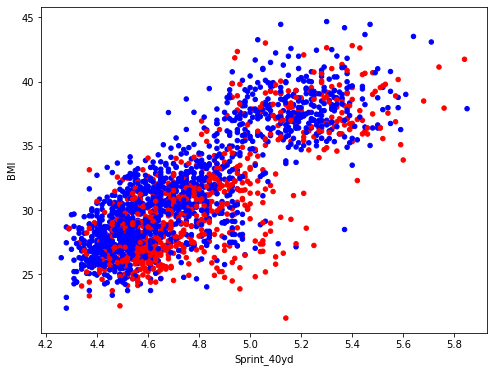

In [684]:
X2d_train.plot.scatter("Sprint_40yd", "BMI", c=y_train.map(drafted_color_map), figsize=(8, 6));

- Applichiamo un filtro di *standardizzazione* alle **features** in quanto esse hanno *scale* molto diverse.

In [685]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X2dn_train = scaler.fit_transform(X2d_train)
X2dn_val = scaler.transform(X2d_val)

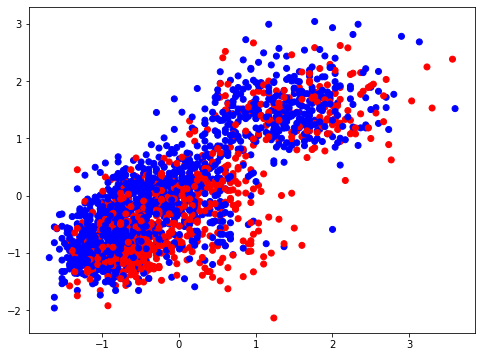

In [686]:
plt.figure(figsize=(8, 6))
plt.scatter(X2dn_train[:, 0], X2dn_train[:, 1], c=y_train.map(drafted_color_map));

- Per addestrare un classificatore lineare, dobbiamo individuare **una retta che separi i punti rossi dai punti blu**.
- In seguito, ciascuna nuova osservazione sarà classificata "Yes" (blu) o "No" (rossa) a seconda del lato della retta su cui si trova.



- Creiamo quindi un semplice modello di classificazione, il `Perceptron`:




In [687]:
from sklearn.linear_model import Perceptron
model = Perceptron(random_state=42)

- Addestriamo il modello sul training set standardizzato. 

In [688]:
model.fit(X2dn_train, y_train);

- Di seguito sono stampati i valori di `w` e di `b` che ci permetteranno poi di rappresentare *l'iperpiano di separazione* che divide le istanze drafted da quelle non drafted.

In [689]:
model.coef_[0]

array([-0.67895336,  1.22741911])

In [690]:
model.intercept_[0]

2.0

- Le classi di classificazione sono salvate all'interno del modello.

In [691]:
model.classes_

array(['No', 'Yes'], dtype='<U3')

- Nelle celle sottostanti sono riportate due funzioni:
  - La prima, `separator_2d`: si occupa di ritornare la retta del modello in forma $ x_2 = -\frac{w_1}{w_2}\cdot x_1-\frac{b}{w_2} $
  - La seconda, `plot_separator_on_data`: visualizza la retta, che rappresenta l'iperpiano di separazione, sui dati colorati per classe.

In [692]:
def separator_2d(model, x1):
  w = model.coef_[0]
  b = model.intercept_[0]
  return -x1 * w[0] / w[1] - b / w[1]

In [693]:
def plot_separator_on_data(X, y, model=None):
  X = np.array(X)
  colors = pd.Series(y).map(drafted_color_map)
  plt.figure(figsize=(8, 6))
  plt.scatter(X[:, 0], X[:, 1], c=colors)
  if model is not None:
    xlim, ylim = plt.xlim(), plt.ylim()
    sep_x = np.linspace(*xlim, 2)
    sep_y = separator_2d(model, sep_x)
    plt.plot(sep_x, sep_y, c="green", linewidth=2)
    plt.xlim(xlim); plt.ylim(ylim)

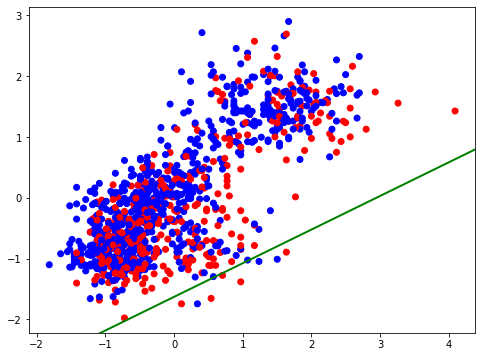

In [694]:
plot_separator_on_data(X2dn_val, y_val, model)

- Osserviamo che le classi sono nettamente **sbilanciate** a causa della posizione della retta.
- Proviamo a calcolare lo score del modello:

In [695]:
model.score(X2dn_val, y_val)

0.6684831970935513

- L'accuratezza è al 67% circa, ma siccome le classi sono sbilanciate quella utilizzata potrebbe non essere una misura d'errore adatta, meglio provarne anche di altre.
- Calcoliamo quindi una `confusion_matrix` o matrice di confusione per osservare quante classificazioni sono andate a buon fine per entrambe le classi:

In [696]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X2dn_val)
cm = confusion_matrix(y_val, y_pred)

In [697]:
pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

,No,Yes
No,5,362
Yes,3,731


- Notiamo che gli `Yes` sono stati classificati correttamente fatta eccezione per 3 istanze.
- Per quanto riguarda i `No` invece le classificazioni sono tutte sbagliate tranne per 5 istanze.
- Questo conferma il fatto che le classi siano sbilanciate e lo score iniziale non sia stato del tutto accurato.
- E' meglio per cui provare un'altra metrica, l'`f1_score`, anche detta **F1-Measure**, *media armonica* tra **precision** e **recall**:

In [698]:
from sklearn.metrics import f1_score

In [699]:
f1_score(y_val, y_pred, average=None)

array([0.02666667, 0.80021894])

- Note le accuratezze sulle singole classi, sappiamo per certo ora che il modello da noi creato non è sufficente a fare predizioni accurate in quanto la classificazione è sbilanciata verso una classe.
- Ciò comporta una scarsa accuratezza sul totale, lo possiamo vedere qui sotto: 

In [700]:
f1_score(y_val, y_pred, average="macro")

0.41344280240831965

### Modello di classificazione lineare con tutte le feature e pre-processing dei dati
Non soddisfatti dai risultati ottenuti abbiamo deciso di utiizzare nuovamente il `Perceptron`, questa volta inserendo più **features** all'interno della variabile `X2d`.<br />
Ciò ci rende difficile una rappresentazione grafica dei risultati, quindi ci limiteremo a verificare l'accuratezza del modello a livello numerico.

Procediamo preparando i dati per il nostro modello:
- Per prima cosa eliminiamo tutte le colonne che non ci servono(`not_features`) e tutte le istanze, o righe, dove vi è almeno un valore `NaN`.

In [701]:
dataset_relevant_features = dataset.drop(columns=not_features)

In [702]:
dataset_relevant_features.shape

(3477, 12)

In [703]:
dataset_relevant_features.dropna(inplace=True)

In [704]:
dataset_relevant_features.shape

(1731, 12)

- Le istanze ora sono circa la metà di prima, ma non vi sono più valori nulli.<br /> Lo si può osservare nella tabella qui sotto:

In [705]:
dataset_relevant_features

,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,BMI,Position,Drafted
Year,,,,,,,,,,,,
2009,Illinois,1.8796,118.387609,4.84,83.82,27.0,292.10,7.38,4.45,33.510073,DE,Yes
2009,Alabama,1.8034,92.079251,4.49,93.98,15.0,304.80,7.09,4.23,28.312463,FS,Yes
2009,Connecticut,1.8796,110.676538,4.76,92.71,26.0,304.80,7.10,4.40,31.327425,OLB,Yes
2009,North Carolina,2.0320,140.160042,5.32,55.88,19.0,238.76,7.87,4.88,33.945078,OT,Yes
2009,Richmond,1.8796,120.655570,4.53,88.90,28.0,304.80,7.46,4.43,34.152029,DE,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
2019,Alabama St.,1.9558,146.056743,5.05,74.93,21.0,261.62,8.34,4.87,38.183236,OT,No
2019,Florida,1.8034,95.254398,4.48,91.44,17.0,297.18,7.03,4.20,29.288755,S,No
2019,Malone University (Ohio),1.8542,97.522360,4.43,96.52,13.0,307.34,7.00,4.22,28.365539,WR,No


- Risultano due feature con dati categorici: `School`, `Position`.
- In virtù di ciò è ora importante differenziare in due matrici le *variabili* **numeriche** da quelle **categoriche**, in modo da poter *pre-processare* correttamente entrambi i tipi. <br />In questo caso può essere fatto attraverso un `ColumnTransformer`.
- Prima però definiamo la variabile `target` la quale ora rappresenta la colonna degli esiti `Drafted`, che viene poi eliminata da `dataset_relevant_features`, ossia il *DataFrame* ottenuto al passo precedente.

In [706]:
target = dataset_relevant_features["Drafted"]
dataset_relevant_features.drop(columns=["Drafted"], inplace=True)

- Con lo stesso metodo salviamo in `categorical_features`, che è un *DataFrame*, i dati relativi a `School` e `Position`.
- Questo per ricavare poi *due liste* con le *intestazioni* di tutte le colonne **categoriche** e **numeriche**.

In [707]:
categorical_features = dataset_relevant_features[["School", "Position"]]
dataset_relevant_features.drop(columns=["School", "Position"], inplace=True)

In [708]:
numeric_values = dataset_relevant_features.columns.to_list()
categorical_values = categorical_features.columns.to_list()

In [709]:
numeric_values

['Height',
 'Weight',
 'Sprint_40yd',
 'Vertical_Jump',
 'Bench_Press_Reps',
 'Broad_Jump',
 'Agility_3cone',
 'Shuttle',
 'BMI']

In [710]:
categorical_values

['School', 'Position']

- Ora riassembliamo le due matrici ottenendo `X2d`, una versione di `dataset_relevant_features` ma senza la colonna `Drafted`, inoltre la colonna `School` è la penultima piuttosto che prima.

In [711]:
X2d = pd.DataFrame(
    np.c_[dataset_relevant_features, categorical_features], 
    index=dataset_relevant_features.index, 
    columns=numeric_values + categorical_values
)

In [712]:
X = X2d
X

,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,BMI,School,Position
Year,,,,,,,,,,,
2009,1.8796,118.387609,4.84,83.82,27.0,292.1,7.38,4.45,33.510073,Illinois,DE
2009,1.8034,92.079251,4.49,93.98,15.0,304.8,7.09,4.23,28.312463,Alabama,FS
2009,1.8796,110.676538,4.76,92.71,26.0,304.8,7.1,4.4,31.327425,Connecticut,OLB
2009,2.032,140.160042,5.32,55.88,19.0,238.76,7.87,4.88,33.945078,North Carolina,OT
2009,1.8796,120.65557,4.53,88.9,28.0,304.8,7.46,4.43,34.152029,Richmond,DE
...,...,...,...,...,...,...,...,...,...,...,...
2019,1.9558,146.056743,5.05,74.93,21.0,261.62,8.34,4.87,38.183236,Alabama St.,OT
2019,1.8034,95.254398,4.48,91.44,17.0,297.18,7.03,4.2,29.288755,Florida,S
2019,1.8542,97.52236,4.43,96.52,13.0,307.34,7.0,4.22,28.365539,Malone University (Ohio),WR


#### Pre-processing dei dati numerici e categorici
- E' giunto ora il momento di attuare delle trasformazioni sui dati.
- Utilizziamo, come già anticipato, un `ColumnTransformer` per gestire sia variabili numeriche che categoriche rispettivamente attraverso uno `StandardScaler`, che attua una standardizzazione dei dati, ed un `OneHotEncoder`, che *trasforma* le variabili categoriche in numeriche.
- Abbiamo scelto di usare il `OneHotEncoder` fuori da una `Pipeline` e su tutti i dati perchè nel validation set sono presenti istanze con valori non noti tramite il training set.

In [713]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

In [714]:
transformer = ColumnTransformer([
    ("numeric", StandardScaler(), numeric_values),
    ("categorical", OneHotEncoder(drop="first", sparse=False), categorical_values)
])

In [715]:
X2d_processed = transformer.fit_transform(X2d)

In [716]:
features_after_processing = X2d.columns[:-2].to_list() + transformer.named_transformers_["categorical"].get_feature_names_out(["School", "Position"]).tolist()

In [717]:
pd.set_option("display.max_columns", 243)
pd.DataFrame(
    X2d_processed,
    index=X2d.index,
    columns=features_after_processing
)

,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,BMI,School_Air Force,School_Akron,School_Alabama,School_Alabama A&M,School_Alabama St.,School_Alcorn St.,School_Appalachian St.,School_Arizona,School_Arizona St.,School_Ark-Pine Bluff,School_Arkansas,School_Arkansas St.,School_Ashland,School_Auburn,School_BYU,School_Ball St.,School_Baylor,School_Bloomsburg,School_Boise St.,School_Boston Col.,School_Bucknell,School_Buffalo,School_Cal Poly,School_California,School_California (PA),School_Central Arkansas,School_Central Florida,School_Central Michigan,School_Chadron St.,School_Charleston Southern,School_Charlotte,School_Cincinnati,School_Citadel,School_Clemson,School_Coastal Carolina,School_Colorado,School_Colorado St.,School_Concordia (MN),School_Connecticut,School_Cornell,School_Duke,School_East Carolina,School_East. Kentucky,School_East. Washington,School_Elon,School_Ferris St.,School_Florida,School_Florida A&M,School_Florida Atlantic,School_Florida St.,School_Fordham,School_Fresno St.,School_Furman,School_Georgia,School_Georgia Southern,School_Georgia St.,School_Georgia Tech,School_Glenville State,School_Grand Valley St.,School_Harding,School_Hartwick,School_Harvard,School_Hawaii,School_Hillsdale,School_Hobart & William Smith,School_Houston,School_Howard,School_Humboldt St.,School_Idaho,School_Illinois,School_Illinois St.,School_Indiana,School_Indiana (PA),School_Iowa,School_Iowa St.,School_Jackson St.,School_Jacksonville St.,School_James Madison,School_Kansas,School_Kansas St.,School_Kent St.,School_Kentucky,School_Kutztown Pennsylvania,School_LSU,School_Lafayette,School_Lehigh,School_Liberty,School_Lindenwood,School_Louisiana,School_Louisiana Tech,School_Louisiana-Lafayette,School_Louisville,School_Maine,School_Malone University (Ohio),School_Marshall,School_Maryland,School_Massachusetts,School_McNeese St.,School_Memphis,School_Miami (FL),School_Miami (OH),School_Michigan,School_Michigan St.,School_Middle Tennessee St.,School_Midwestern St.,School_Minnesota,School_Mississippi,School_Mississippi St.,School_Missouri,School_Missouri Southern,School_Missouri State,School_Missouri Western St.,School_Montana,School_Montana St.,School_Mount Union,School_NW State (LA),School_Nebraska,School_Nevada,School_New Hampshire,School_New Mexico,School_New Mexico St.,School_Newberry,School_Nicholls St.,School_Norfolk St.,School_North Carolina,School_North Carolina Central,School_North Carolina St.,School_North Dakota St.,School_Northern Colorado,School_Northern Illinois,School_Northwest Missouri State,School_Northwestern,School_Northwestern St. (LA),School_Notre Dame,School_Ohio,School_Ohio St.,School_Oklahoma,School_Oklahoma St.,School_Old Dominion,School_Oregon,School_Oregon St.,School_Penn St.,School_Pittsburgh,School_Portland St.,School_Presbyterian,School_Princeton,School_Purdue,School_Rice,School_Richmond,School_Rutgers,School_SE Louisiana,School_SMU,School_Saginaw Valley St.,School_Samford,School_San Diego St.,School_San Jose St.,School_Shepherd,School_Sioux Falls,School_Slippery Rock,School_South Alabama,School_South Carolina,School_South Carolina St.,School_South Dakota,School_South Dakota St.,School_South Florida,School_Southern Arkansas,School_Southern Illinois,School_Southern Miss,School_Southern Utah,School_Stanford,School_Stephen F. Austin,School_Syracuse,School_TCU,School_Temple,School_Tenn-Chattanooga,School_Tennessee,School_Tennessee St.,School_Tennessee Tech,School_Tennessee-Martin,School_Texas,School_Texas A&M,School_Texas St.,School_Texas Tech,School_Texas-El Paso,School_Texas-San Antonio,School_Toledo,School_Towson,School_Troy,School_Tulane,School_Tulsa,School_UCLA,School_UNLV,School_USC,School_Utah,School_Utah St.,School_Valdosta St.,School_Vanderbilt,School_Villanova,School_Virginia,School_Virginia Tech,School_Wagner,School_Wake Forest,School_Washburn,School_Washington,School_Washington St.,School_Wayne State (MI),School_Weber St.,School_West Georgia,School_West Liberty,School_Wes

In [718]:
y_train.value_counts()

Yes    1421
No      781
Name: Drafted, dtype: int64

In [719]:
pd.reset_option("display.max_columns")

In [720]:
len(transformer.named_transformers_["categorical"].get_feature_names_out(["School", "Position"]))

234

In [721]:
y = target

In [722]:
X2d_train, X2d_val, y_train, y_val = train_test_split(
    X2d_processed, y,           # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

- Utilizziamo sempre un modello `Perceptron` di classificazione lineare.

In [723]:
model = Perceptron(random_state=42)

In [724]:
model.fit(X2d_train, y_train);

In [725]:
model.score(X2d_val, y_val)

0.7227036395147314

- Apparentemente sembra che il modello sia migliorato, ma scaviamo più a fondo:


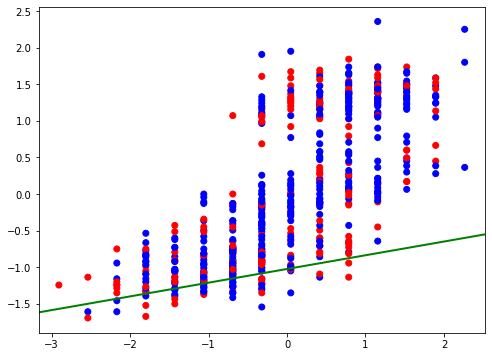

In [726]:
plot_separator_on_data(X2d_val, y_val, model)

In [727]:
y_pred = model.predict(X2d_val)

- Calcoliamo la **matrice di confusione**:

In [728]:
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

,No,Yes
No,63,125
Yes,35,354


- Sembra leggermente più  bilanciata rispetto al modello precedente, proviamo a vedere che `f1_score` ottiene, prima per ogni classe e poi in media.

In [729]:
f1_score(y_val, y_pred, average=None)

array([0.44055944, 0.8156682 ])

In [730]:
f1_score(y_val, y_pred, average="macro")

0.6281138216622087

- Il modello ha guadagnato il 42% nell'accuratezza relativa alla classe `No`, ed anche nell'altro caso, per `Yes`, l'accuratezza è migliorata dell'1% circa.
- L'accuratezza sul totale invece è migliorata del 20% circa, arrivando al 62%, ma questo ancora non è sufficente.

### Modello di classificazione lineare con tutte le features, pre-processing dei dati, features polinomiali, regolarizzazione e bilanciamento classi
Non convinti nel modello precedente adottiamo ora un'altro algoritmo chiamato **Regressione Logistica**, grazie al quale possiamo introdurre la *regolarizzazione* al fine di verificare quali siano le features più e meno significative.
Qui in seguito è riportata una breve descrizione di questo algoritmo presa dal laboratorio sulla classificazione:
- La regressione _logistica_ è un modello di classificazione binaria basato sulla regressione lineare
- Sia data una variabile y pari a 1 per gli esempi di una classe (positiva) e -1 per quelli dell'altra (negativa), si minimizza la funzione
$$ \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1) $$

Procediamo creando una `Pipeline` contenente il filtro per trasformare le feature in forma polinomiali di gradi superiori al 1°, che per il momento rimane inutilizzato, e il modello da utilizzare.

In [731]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

model = Pipeline([
    ("poly", PolynomialFeatures(degree=1, include_bias=False)),
    ("logregr", LogisticRegression(solver="saga", random_state=42, C=0.001, class_weight={"Yes": 1, "No": 2}))
])

- `solver` indica quale implementazione usare tra diverse disponibili per il training, `"saga"` è l'unica a supportare tutte le opzioni per la regolarizzazione.
- `class_weight` indica il peso da dare a ciascuna classe in fase di training, nel nostro caso sappiamo dall'analisi sui dati che `"Yes"` copre il 70% delle istanze mentre `"No"` il 30%. Proviamo quindi a pesare 1:2 le due classi, sarebbe più corretto pesarle 1:2.3 ma vedremo successivamente cosa succede così facendo.
- Qui sotto invece utilizziamo il training set ed il validation set creati per il modello precedente, in modo che vengano sfruttati anche in questo caso la **standardizzazione** ed il **OneHotEncoding**.

In [732]:
model.fit(X2d_train, y_train);

- In questo caso omettiamo la colonna degli indici in quanto sono aumentati polinomialmente secondo il filtro utilizzato nella pipeline che costituisce il modello.

In [733]:
pd.set_option("display.max_rows", 244)
pd.Series(list(model.named_steps["logregr"].coef_[0]) + [model.named_steps["logregr"].intercept_[0]])

0      0.032957
1      0.048286
2     -0.049411
3      0.050356
4      0.097745
5      0.047505
6     -0.024799
7     -0.029028
8      0.045131
9     -0.000996
10     0.000454
11     0.002498
12     0.000000
13     0.000000
14     0.000000
15    -0.000160
16     0.001689
17    -0.002059
18     0.000000
19     0.000821
20    -0.000030
21     0.000423
22    -0.001716
23    -0.004984
24    -0.001450
25     0.002140
26    -0.000672
27     0.003924
28    -0.005313
29    -0.001001
30     0.001355
31     0.000473
32     0.004416
33     0.000000
34     0.000000
35     0.000239
36    -0.000107
37     0.000000
38    -0.001014
39     0.000000
40    -0.000597
41     0.000934
42     0.005284
43     0.000985
44     0.000146
45    -0.001107
46     0.000000
47     0.000585
48     0.000441
49    -0.001511
50    -0.001354
51    -0.001003
52    -0.002933
53    -0.000563
54    -0.001012
55     0.005038
56     0.000465
57     0.000512
58     0.002432
59     0.000000
60    -0.006157
61    -0.001124
62     0

In [734]:
pd.reset_option("display.max_rows")

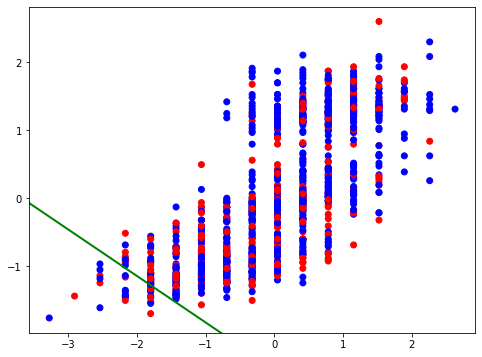

In [735]:
plot_separator_on_data(X2d_train, y_train, model.named_steps["logregr"])

In [736]:
model.score(X2d_val, y_val)

0.7140381282495667

In [737]:
y_pred = model.predict(X2d_val)

In [738]:
pd.DataFrame(
    confusion_matrix(y_val, y_pred),
    columns=model.classes_,
    index=model.classes_
)

,No,Yes
No,72,116
Yes,49,340


In [739]:
f1_score(y_val, y_pred, average=None)

array([0.46601942, 0.80473373])

In [740]:
f1_score(y_val, y_pred, average="macro")

0.6353765726431895

#### Grid Search e Randomized Search
- Dato il risultato ottenuto dalla **Regressione Logistica** con valore del parametro  `C`=**0.001** (default), abbiamo deciso di effettuare un ulteriore test utilizzando la `GridSearchCV`, inserendo come valori di `C`: **0.001**, **10**, **1000**. Vengono utilizzati diversi tipi di regolarizzazione(`l1`, `l2`, `elasticnet`) sfruttando `elasticnet` come `penalty`, con valori differenti da testare per il parametro `l1_ratio`, avremo ad esempio 0 per L2 e 1 per L1 mentre tutti i valori di mezzo offriranno una variante tra le due regolarizzazioni.
- Utilizzando la stessa `grid` viene mostrata anche una `RandomizedSearchCV` per permettere di ottenere un risultato in un tempo nettamente minore, sebbene più impreciso.
- Decidere quindi in base alle esigenze temporali nell'utilizzo di questo notebook se eseguire una `GridSearchCV` o una `RandomizedSearchCV`.

In [741]:
grid = {
        "poly__degree": [1, 2],
        "logregr__class_weight": [
            {"Yes": 1, "No": 2},
            {"Yes": 1, "No": 2.3}
        ],
        "logregr__C": [1000, 10, 0.001],
        "logregr__penalty": ["elasticnet"],
        "logregr__l1_ratio": [0, 0.2, 0.5, 1]
}

In [742]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(3, shuffle=True, random_state=42)

In [743]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
gs = GridSearchCV(model, grid, cv=skf, scoring=make_scorer(f1_score, average="macro"), n_jobs=-1)
rs = RandomizedSearchCV(model, grid, cv=skf, scoring=make_scorer(f1_score, average="macro"), n_jobs=-1)

In [744]:
# GRID SEARCH
%%time
gs.fit(X2d_train, y_train);

CPU times: user 1min 23s, sys: 2.79 s, total: 1min 25s
Wall time: 31min 38s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=1,
                                                           include_bias=False)),
                                       ('logregr',
                                        LogisticRegression(C=0.001,
                                                           class_weight={'No': 2,
                                                                         'Yes': 1},
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logregr__C': [1000, 10, 0.001],
                         'logregr__class_weight': [{'No': 2, 'Yes': 1},
                                                   {'No': 2.3, 'Yes': 1}],
                         'logregr__l1_ratio': [0, 0.2, 0.5

In [745]:
# RANDOMIZED SEARCH
%%time
rs.fit(X2d_train, y_train);

CPU times: user 48.6 s, sys: 213 ms, total: 48.8 s
Wall time: 2min 18s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('poly',
                                              PolynomialFeatures(degree=1,
                                                                 include_bias=False)),
                                             ('logregr',
                                              LogisticRegression(C=0.001,
                                                                 class_weight={'No': 2,
                                                                               'Yes': 1},
                                                                 random_state=42,
                                                                 solver='saga'))]),
                   n_jobs=-1,
                   param_distributions={'logregr__C': [1000, 10, 0.001],
                                        'logregr__class_weight': [{'No': 2,
                                                

In [746]:
# GRID SEARCH
gs.best_params_

{'logregr__C': 10,
 'logregr__class_weight': {'Yes': 1, 'No': 2.3},
 'logregr__l1_ratio': 0.2,
 'logregr__penalty': 'elasticnet',
 'poly__degree': 2}

In [747]:
# RANDOMIZED SEARCH
rs.best_params_

{'poly__degree': 2,
 'logregr__penalty': 'elasticnet',
 'logregr__l1_ratio': 0,
 'logregr__class_weight': {'Yes': 1, 'No': 2},
 'logregr__C': 1000}

In [748]:
# GRID SEARCH
gscv_results = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")
gscv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logregr__C,param_logregr__class_weight,param_logregr__l1_ratio,param_logregr__penalty,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
27,74.662649,0.411390,0.119566,0.037724,10,"{'Yes': 1, 'No': 2.3}",0.2,elasticnet,2,"{'logregr__C': 10, 'logregr__class_weight': {'...",0.627353,0.641955,0.640209,0.636506,0.006511,1
29,74.023428,1.181312,0.090245,0.001441,10,"{'Yes': 1, 'No': 2.3}",0.5,elasticnet,2,"{'logregr__C': 10, 'logregr__class_weight': {'...",0.627353,0.641955,0.639595,0.636301,0.006400,2
31,75.043521,0.927732,0.104555,0.006743,10,"{'Yes': 1, 'No': 2.3}",1,elasticnet,2,"{'logregr__C': 10, 'logregr__class_weight': {'...",0.627353,0.639703,0.639595,0.635550,0.005796,3
25,55.050538,0.122534,0.096620,0.002039,10,"{'Yes': 1, 'No': 2.3}",0,elasticnet,2,"{'logregr__C': 10, 'logregr__class_weight': {'...",0.621750,0.637391,0.640209,0.633117,0.008119,4
15,74.053160,1.213060,0.085697,0.004082,1000,"{'Yes': 1, 'No': 2.3}",1,elasticnet,2,"{'logregr__C': 1000, 'logregr__class_weight': ...",0.621750,0.637391,0.640209,0.633117,0.008119,4
13,74.057597,1.144081,0.086721,0.009383,1000,"{'Yes': 1, 'No': 2.3}",0.5,elasticnet,2,"{'logregr__C': 1000, 'logregr__class_weight': ...",0.621750,0.637391,0.640209,0.633117,0.008119,4
11,74.801792,0.722015,0.081240,0.008210,1000,"{'Yes': 1, 'No': 2.3}",0.2,elasticnet,2,"{'logregr__C': 1000, 'logregr__class_weight': ...",0.621750,0.637391,0.640209,0.633117,0.008119,4
9,55.015336,0.779314,0.089429,0.011272,1000,"{'Yes': 1, 'No': 2.3}",0,elasticnet,2,"{'logregr__C': 1000, 'logregr__class_weight': ...",0.621750,0.637391,0.640209,0.633117,0.008119,4
23,75.328831,0.802697,0.084395,0.005717,10,"{'Yes': 1, 'No': 2}",1,elasticnet,2,"{'logregr__C': 10, 'logregr__class_weight': {'...",0.632767,0.626155,0.629045,0.629322,0.002707,9
21,73.973824,1.371744,0.096104,0.016974,10,"{'Yes': 1, 'No': 2}",0.5,elasticnet,2,"{'logregr__C': 10, 'logregr__class_weight': {'...",0.630560,0.628356,0.629045,0.629320,0.000921,10


In [749]:
# RANDOMIZED SEARCH
rscv_results = pd.DataFrame(rs.cv_results_).sort_values("rank_test_score")
rscv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,param_logregr__penalty,param_logregr__l1_ratio,param_logregr__class_weight,param_logregr__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,49.327970,10.403657,0.077091,0.015882,2,elasticnet,0,"{'Yes': 1, 'No': 2}",1000,"{'poly__degree': 2, 'logregr__penalty': 'elast...",0.630560,0.630560,0.625084,0.628735,0.002581,1
9,0.629175,0.009702,0.007996,0.001144,1,elasticnet,0.2,"{'Yes': 1, 'No': 2}",10,"{'poly__degree': 1, 'logregr__penalty': 'elast...",0.624661,0.584980,0.573520,0.594387,0.021912,2
3,0.479450,0.001392,0.008509,0.000380,1,elasticnet,0,"{'Yes': 1, 'No': 2}",10,"{'poly__degree': 1, 'logregr__penalty': 'elast...",0.620301,0.588605,0.573520,0.594142,0.019495,3
4,0.631055,0.006744,0.008111,0.000278,1,elasticnet,1,"{'Yes': 1, 'No': 2.3}",10,"{'poly__degree': 1, 'logregr__penalty': 'elast...",0.616932,0.582882,0.572662,0.590825,0.018926,4
2,0.639346,0.008635,0.009238,0.002140,1,elasticnet,1,"{'Yes': 1, 'No': 2}",1000,"{'poly__degree': 1, 'logregr__penalty': 'elast...",0.620301,0.579216,0.569571,0.589696,0.021996,5
8,0.475894,0.015662,0.007437,0.000041,1,elasticnet,0,"{'Yes': 1, 'No': 2}",1000,"{'poly__degree': 1, 'logregr__penalty': 'elast...",0.620301,0.579216,0.569571,0.589696,0.021996,5
7,0.644438,0.018122,0.007919,0.000343,1,elasticnet,0.5,"{'Yes': 1, 'No': 2.3}",1000,"{'poly__degree': 1, 'logregr__penalty': 'elast...",0.614340,0.575068,0.572662,0.587357,0.019105,7
5,0.079129,0.001637,0.008126,0.000193,1,elasticnet,0,"{'Yes': 1, 'No': 2}",0.001,"{'poly__degree': 1, 'logregr__penalty': 'elast...",0.548440,0.537806,0.509301,0.531849,0.016524,8
6,0.024178,0.005289,0.008010,0.000302,1,elasticnet,0.5,"{'Yes': 1, 'No': 2}",0.001,"{'poly__degree': 1, 'logregr__penalty': 'elast...",0.408602,0.408602,0.408320,0.408508,0.000133,9
0,0.024437,0.005365,0.010036,0.003909,1,elasticnet,1,"{'Yes': 1, 'No': 2.3}",0.001,"{'poly__degree': 1, 'logregr__penalty': 'elast...",0.408602,0.408602,0.236581,0.351262,0.081092,10


- Purtroppo anche se più veloce la `RandomizedSearch` non da risultati accurati quanto la `GridSearch` per questo abbiamo deciso di proseguire utilizzando quest'ultima nonostante la lunga attesa per il calcolo degli iperparametri migliori.
- Eventualmente, per saltare questa lunga attesa è possibile utilizzare in ogni caso la `RandomizedSearch` sostituendo nel codice della cella sottostante `gs.best_estimator_` con `rs.best_estimator`.

In [750]:
model = gs.best_estimator_

- Dai risultati ottenuti possiamo osservare che i *modelli* di **Regressione Logistica** con migliore accuratezza sono quelli con parametro  `C`=**0.001**, indipendentemente dal valore degli altri parametri.
- Vediamo come sono state pesate le features:

In [751]:
pd.Series(list(model.named_steps["logregr"].coef_[0]) + [model.named_steps["logregr"].intercept_[0]])

0        0.282862
1        0.568937
2       -1.324243
3        0.075811
4        0.449454
           ...   
29885    0.000000
29886    0.227578
29887    0.000000
29888   -0.192895
29889   -0.253858
Length: 29890, dtype: float64

In [752]:
pd.set_option("display.max_rows", 244)
model_features = pd.Series(list(model.named_steps["logregr"].coef_[0]) + [model.named_steps["logregr"].intercept_[0]])
model_features

0        0.282862
1        0.568937
2       -1.324243
3        0.075811
4        0.449454
           ...   
29885    0.000000
29886    0.227578
29887    0.000000
29888   -0.192895
29889   -0.253858
Length: 29890, dtype: float64

In [753]:
pd.reset_option("display.max_rows")

- Alcune sono addirittura diventate nulle, esse sono le seguenti.

In [754]:
model_features[model_features == 0]

12       0.0
13       0.0
14       0.0
18       0.0
33       0.0
        ... 
29881    0.0
29882    0.0
29884    0.0
29885    0.0
29887    0.0
Length: 26779, dtype: float64

In [755]:
model_features.sort_values(inplace=True)
model_features.tail(30)

2385     0.217140
2268     0.217946
1285     0.225937
29886    0.227578
241      0.227578
55       0.227929
12123    0.227929
82       0.228332
16848    0.228332
1466     0.234731
5        0.240779
1448     0.242734
1031     0.246687
270      0.246836
1439     0.248382
1074     0.249366
507      0.250186
630      0.254775
1675     0.261170
359      0.265192
265      0.268301
0        0.282862
249      0.293559
1198     0.321369
393      0.325065
734      0.338091
388      0.348333
4        0.449454
1        0.568937
8        0.585335
dtype: float64

- Il nostro modello è stato testato soltanto sul training set per ora, è arrivato infatti il momento di testarlo sul validation set per verificarne l'accuratezza.

In [756]:
model.score(X2d_val, y_val)

0.6551126516464472

In [757]:
y_pred = gs.best_estimator_.predict(X2d_val)

In [758]:
f1_score(y_val, y_pred, average="macro")

0.62559955654825

In [759]:
from sklearn.metrics import precision_score, recall_score

In [760]:
precision_score(y_val, y_pred, average="macro")

0.6235997482693518

In [761]:
recall_score(y_val, y_pred, average="macro")

0.6342777443526774

- Notiamo che purtroppo anche questo modello non è abbastanza accurato in quanto ha un **F1-Measure** pari a 0.62.

## 3) Generazione di diversi modelli di learning 

Proviamo ad utilizzare ora diversi modelli bilanciando, in maniera differente, le classi del problema, applicando più metodi.

- Partiamo inizializzando una lista che conterrà tutti i nostri modelli migliori:

In [762]:
best_models = []

### Modello analogo al precedente ma bilanciando le classi tramite resampling
- Precedentemente abbiamo sfruttato il parametro `class_weight` offertoci da `sklearn` in modo da pesare le classi sbilanciate. 
- Purtroppo però il risultato non è stato soddisfacente, ragion per cui abbiamo deciso di riprovare con la strada del resampling.
- Utilizzeremo due tecniche per fare resampling e quindi bilanciare le nostre classi:
  - **SMOTE**: acronimo di *Synthetic Minority Oversampling Technique*, tecnica che permette di fare over-sampling della classe minoritaria;
  - **under-sampling**: consiste nell'eliminare alcune istanze della classe maggioritaria dal dataset.

Nello sviluppo delle seguenti tecniche sfrutteremo le funzionalità della libreria esterna `imbalance-learn`.



#### SMOTE
- Procediamo quindi facendo **over-sampling** della *variabile minoritaria* all'interno dell'intero dataset.
- Dopodichè separiamo nuovamente il dataset in *training* e *validation set*.

In [763]:
from imblearn.over_sampling import SMOTE
X_over_sampled, y_over_sampled = SMOTE(random_state=42).fit_resample(X2d_processed, y)
X2d_train, X2d_val, y_train, y_val = train_test_split(
    X_over_sampled, y_over_sampled,           # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

- Creiamo ora una pipeline con al suo interno un modello che non utilizzi il parametro `class_weight`.

In [764]:
model = Pipeline([
    ("poly", PolynomialFeatures(degree=1, include_bias=False)),
    ("logregr", LogisticRegression(solver="saga", random_state=42, C=0.001))
])

- Utilizziamo le stesse combinazioni di iperparametri della grid search precedente, stessa `StratifiedKFold` e stesso `scorer`(metrica: `f1_score`):

In [765]:
grid = {
    "poly__degree": [1, 2],
    "logregr__C": [1000, 10, 0.001],
    "logregr__penalty": ["elasticnet"],
    "logregr__l1_ratio": [0, 0.2, 0.5, 1]
}

In [766]:
gs = GridSearchCV(model, grid, cv=skf, scoring=make_scorer(f1_score, average="macro"))

In [767]:
gs.fit(X2d_train, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

In [768]:
gs.best_params_

{'logregr__C': 1000,
 'logregr__l1_ratio': 0,
 'logregr__penalty': 'elasticnet',
 'poly__degree': 2}

In [769]:
gscv_results = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")
gscv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logregr__C,param_logregr__l1_ratio,param_logregr__penalty,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,42.772020,0.746386,0.118115,0.010106,1000,0,elasticnet,2,"{'logregr__C': 1000, 'logregr__l1_ratio': 0, '...",0.736980,0.753121,0.712972,0.734358,0.016495,1
3,58.710910,1.076244,0.135050,0.008038,1000,0.2,elasticnet,2,"{'logregr__C': 1000, 'logregr__l1_ratio': 0.2,...",0.736980,0.753121,0.712972,0.734358,0.016495,1
5,59.688069,1.168754,0.117665,0.007710,1000,0.5,elasticnet,2,"{'logregr__C': 1000, 'logregr__l1_ratio': 0.5,...",0.736980,0.753121,0.712972,0.734358,0.016495,1
7,59.552150,0.582622,0.105475,0.004859,1000,1,elasticnet,2,"{'logregr__C': 1000, 'logregr__l1_ratio': 1, '...",0.736980,0.753121,0.712972,0.734358,0.016495,1
9,43.412401,1.342764,0.116802,0.006426,10,0,elasticnet,2,"{'logregr__C': 10, 'logregr__l1_ratio': 0, 'lo...",0.736980,0.753121,0.712972,0.734358,0.016495,1
11,58.877029,1.150947,0.115700,0.008562,10,0.2,elasticnet,2,"{'logregr__C': 10, 'logregr__l1_ratio': 0.2, '...",0.735140,0.753121,0.712972,0.733744,0.016420,6
13,59.899681,2.673971,0.123751,0.005944,10,0.5,elasticnet,2,"{'logregr__C': 10, 'logregr__l1_ratio': 0.5, '...",0.731330,0.753170,0.711116,0.731872,0.017173,7
15,59.138880,1.083058,0.116163,0.002935,10,1,elasticnet,2,"{'logregr__C': 10, 'logregr__l1_ratio': 1, 'lo...",0.727649,0.757010,0.709171,0.731276,0.019698,8
14,0.535208,0.015166,0.013819,0.004541,10,1,elasticnet,1,"{'logregr__C': 10, 'logregr__l1_ratio': 1, 'lo...",0.688615,0.698253,0.696262,0.694377,0.004154,9
12,0.533303,0.004949,0.011514,0.001493,10,0.5,elasticnet,1,"{'logregr__C': 10, 'logregr__l1_ratio': 0.5, '...",0.688480,0.698253,0.696262,0.694332,0.004217,10


In [770]:
model = gs.best_estimator_

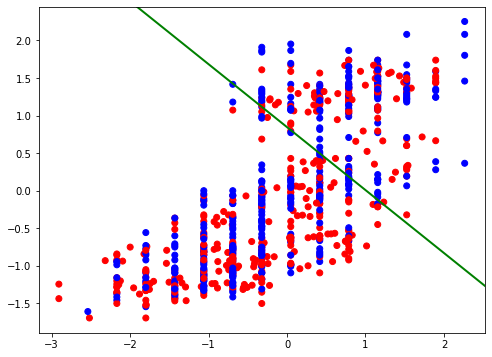

In [771]:
plot_separator_on_data(X2d_val, y_val, model.named_steps["logregr"])

In [772]:
pd.Series(list(model.named_steps["logregr"].coef_[0]) + [model.named_steps["logregr"].intercept_[0]])

0        0.493113
1        0.588476
2       -1.525939
3        0.299665
4        0.445537
           ...   
29885   -0.002650
29886    0.098715
29887    0.000000
29888   -0.301902
29889   -0.497913
Length: 29890, dtype: float64

In [773]:
pd.set_option("display.max_rows", 244)
model_features = pd.Series(list(model.named_steps["logregr"].coef_[0]) + [model.named_steps["logregr"].intercept_[0]])
model_features

0        0.493113
1        0.588476
2       -1.525939
3        0.299665
4        0.445537
           ...   
29885   -0.002650
29886    0.098715
29887    0.000000
29888   -0.301902
29889   -0.497913
Length: 29890, dtype: float64

In [774]:
pd.reset_option("display.max_rows")

In [775]:
model_features[model_features == 0]

18       0.0
33       0.0
39       0.0
63       0.0
84       0.0
        ... 
29880    0.0
29881    0.0
29882    0.0
29884    0.0
29887    0.0
Length: 26253, dtype: float64

In [776]:
model.score(X2d_val, y_val)

0.6927939317319848

In [777]:
y_pred = gs.best_estimator_.predict(X2d_val)

In [778]:
f1_score(y_val, y_pred, average="macro")

0.6920063261019

In [779]:
precision_score(y_val, y_pred, average="macro")

0.6970753173923203

In [780]:
recall_score(y_val, y_pred, average="macro")

0.6942013968838745

- L'accuratezza del modello è migliorata del 6% circa grazie a `SMOTE`.
- Sembra quindi essere più accurato rispetto al bilanciamento definito tramite `class_weight`.

##### Varianti di SMOTE

Per tutte le varianti scegliamo di utilizzare un modello di regressione logistica con gli iperparametri trovati nella precedente grid-search:
  - `logregr__C` = 1000
  - `logregr__l1_ratio` = 0
  - `logregr__penalty` = 'elasticnet'
  - `poly__degree` = 2



###### BorderlineSMOTE


In [781]:
from imblearn.over_sampling import BorderlineSMOTE
X_over_sampled, y_over_sampled = BorderlineSMOTE(random_state=42).fit_resample(X2d_processed, y)
X2d_train, X2d_val, y_train, y_val = train_test_split(
    X_over_sampled, y_over_sampled,           # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

In [782]:
model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("logregr", LogisticRegression(solver="saga", random_state=42, C=1000, penalty="elasticnet", l1_ratio=0))
])

In [783]:
model.fit(X2d_train, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


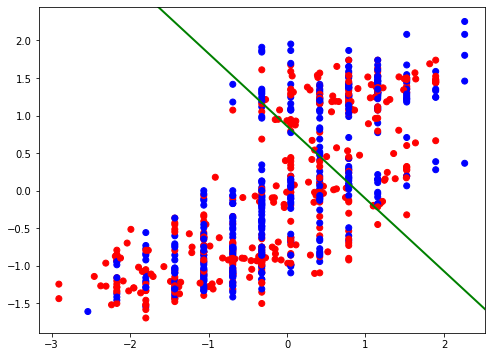

In [784]:
plot_separator_on_data(X2d_val, y_val, model.named_steps["logregr"])

In [785]:
model.score(X2d_val, y_val)

0.6637168141592921

In [786]:
f1_score(y_val, model.predict(X2d_val), average="macro")

0.6630571249215317

In [787]:
precision_score(y_val, model.predict(X2d_val), average="macro")

0.6669179695589149

In [788]:
recall_score(y_val, model.predict(X2d_val), average="macro")

0.6649749277253307

In [789]:
pd.DataFrame(confusion_matrix(y_val, model.predict(X2d_val)), index=model.classes_, columns=model.classes_)

,No,Yes
No,280,107
Yes,159,245


- Con BorderlineSMOTE notiamo un aumento dell'accuratezza del modello che passa da un `f1-score` di *0.62* a circa *0.66*

###### SVMSMOTE


In [790]:
from imblearn.over_sampling import SVMSMOTE
X_over_sampled, y_over_sampled = SVMSMOTE(random_state=42).fit_resample(X2d_processed, y)
X2d_train, X2d_val, y_train, y_val = train_test_split(
    X_over_sampled, y_over_sampled,           # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

In [791]:
model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("logregr", LogisticRegression(solver="saga", random_state=42, C=1000, penalty="elasticnet", l1_ratio=0))
])

In [792]:
model.fit(X2d_train, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


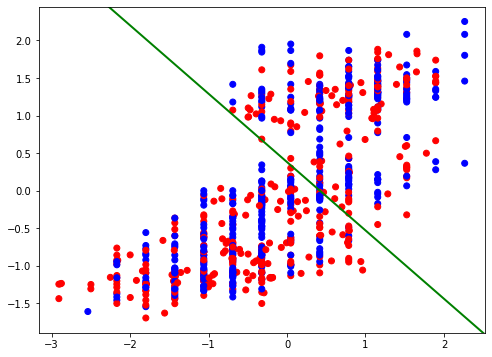

In [793]:
plot_separator_on_data(X2d_val, y_val, model.named_steps["logregr"])

In [794]:
model.score(X2d_val, y_val)

0.695322376738306

In [795]:
f1_score(y_val, model.predict(X2d_val), average="macro")

0.695322376738306

In [796]:
precision_score(y_val, model.predict(X2d_val), average="macro")

0.6956436922762044

In [797]:
recall_score(y_val, model.predict(X2d_val), average="macro")

0.6956436922762044

In [798]:
pd.DataFrame(confusion_matrix(y_val, model.predict(X2d_val)), index=model.classes_, columns=model.classes_)

,No,Yes
No,275,112
Yes,129,275


- SVMSMOTE presenta ancora un miglioramento rispetto alla versione originale di SMOTE(+7%), oltre che su BorderlineSMOTE(+3%). 

- Proviamo a vedere che cosa succede invece se si applica **under-sampling** alla classe maggioritaria, sfruttiamo sempre `imbalanced-learn`.

#### Under-sampling
- Procediamo quindi facendo **under-sampling** della *variabile maggioritaria* all'interno dell'intero dataset.
- Dopodichè separiamo nuovamente il dataset in *training* e *validation set*.

In [799]:
from imblearn.under_sampling import ClusterCentroids
X_under_sampled, y_under_sampled = ClusterCentroids(random_state=42).fit_resample(X2d_processed, y)
X2d_train, X2d_val, y_train, y_val = train_test_split(
    X_under_sampled, y_under_sampled,           # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

- Creiamo ora una pipeline con al suo interno un modello che non utilizzi il parametro `class_weight`.

In [800]:
model = Pipeline([
    ("poly", PolynomialFeatures(degree=1, include_bias=False)),
    ("logregr", LogisticRegression(solver="saga", random_state=42, C=0.001))
])

- Utilizziamo le stesse combinazioni di iperparametri della grid search precedente, stessa `StratifiedKFold` e stesso `scorer`(metrica: `f1_score`):

In [801]:
grid = {
    "poly__degree": [1, 2],
    "logregr__C": [1000, 10, 0.001],
    "logregr__penalty": ["elasticnet"],
    "logregr__l1_ratio": [0, 0.2, 0.5, 1]
}

In [802]:
gs = GridSearchCV(model, grid, cv=skf, scoring=make_scorer(f1_score, average="macro"))

In [803]:
gs.fit(X2d_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=1,
                                                           include_bias=False)),
                                       ('logregr',
                                        LogisticRegression(C=0.001,
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid={'logregr__C': [1000, 10, 0.001],
                         'logregr__l1_ratio': [0, 0.2, 0.5, 1],
                         'logregr__penalty': ['elasticnet'],
                         'poly__degree': [1, 2]},
             scoring=make_scorer(f1_score, average=macro))

In [804]:
gs.best_params_

{'logregr__C': 10,
 'logregr__l1_ratio': 0.2,
 'logregr__penalty': 'elasticnet',
 'poly__degree': 2}

In [805]:
gscv_results = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")
gscv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logregr__C,param_logregr__l1_ratio,param_logregr__penalty,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
11,27.017923,0.608431,0.061574,0.001336,10,0.2,elasticnet,2,"{'logregr__C': 10, 'logregr__l1_ratio': 0.2, '...",0.659272,0.640478,0.591667,0.630472,0.028492,1
13,26.300932,0.254792,0.059423,0.007066,10,0.5,elasticnet,2,"{'logregr__C': 10, 'logregr__l1_ratio': 0.5, '...",0.654898,0.640478,0.591667,0.629014,0.027057,2
1,20.076390,0.437126,0.090334,0.045994,1000,0,elasticnet,2,"{'logregr__C': 1000, 'logregr__l1_ratio': 0, '...",0.659272,0.631430,0.596132,0.628945,0.025836,3
3,27.423388,0.389840,0.059246,0.003010,1000,0.2,elasticnet,2,"{'logregr__C': 1000, 'logregr__l1_ratio': 0.2,...",0.659272,0.631430,0.596132,0.628945,0.025836,3
5,26.759761,0.229170,0.058549,0.001691,1000,0.5,elasticnet,2,"{'logregr__C': 1000, 'logregr__l1_ratio': 0.5,...",0.659272,0.631430,0.596132,0.628945,0.025836,3
7,26.808223,0.605784,0.060024,0.001159,1000,1,elasticnet,2,"{'logregr__C': 1000, 'logregr__l1_ratio': 1, '...",0.659272,0.631430,0.596132,0.628945,0.025836,3
9,19.784909,0.425541,0.058479,0.000591,10,0,elasticnet,2,"{'logregr__C': 10, 'logregr__l1_ratio': 0, 'lo...",0.659272,0.631430,0.596132,0.628945,0.025836,3
15,27.058160,1.296955,0.062126,0.001227,10,1,elasticnet,2,"{'logregr__C': 10, 'logregr__l1_ratio': 1, 'lo...",0.646582,0.640478,0.592256,0.626439,0.024299,8
10,0.275921,0.006956,0.006694,0.000298,10,0.2,elasticnet,1,"{'logregr__C': 10, 'logregr__l1_ratio': 0.2, '...",0.592788,0.621481,0.588880,0.601050,0.014535,9
8,0.227081,0.001504,0.006666,0.000520,10,0,elasticnet,1,"{'logregr__C': 10, 'logregr__l1_ratio': 0, 'lo...",0.588880,0.625263,0.584963,0.599702,0.018145,10


In [806]:
model = gs.best_estimator_

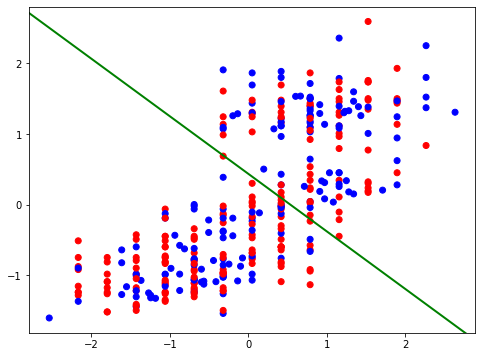

In [807]:
plot_separator_on_data(X2d_val, y_val, model.named_steps["logregr"])

In [808]:
pd.Series(list(model.named_steps["logregr"].coef_[0]) + [model.named_steps["logregr"].intercept_[0]])

0        0.367639
1        0.450482
2       -0.911048
3        0.164284
4        0.379600
           ...   
29885    0.000000
29886    0.108590
29887    0.000000
29888   -0.211835
29889   -0.195734
Length: 29890, dtype: float64

In [809]:
pd.set_option("display.max_rows", 244)
model_features = pd.Series(list(model.named_steps["logregr"].coef_[0]) + [model.named_steps["logregr"].intercept_[0]])
model_features

0        0.367639
1        0.450482
2       -0.911048
3        0.164284
4        0.379600
           ...   
29885    0.000000
29886    0.108590
29887    0.000000
29888   -0.211835
29889   -0.195734
Length: 29890, dtype: float64

In [810]:
pd.reset_option("display.max_rows")

In [811]:
model_features[model_features == 0]

9        0.0
10       0.0
14       0.0
21       0.0
29       0.0
        ... 
29880    0.0
29881    0.0
29884    0.0
29885    0.0
29887    0.0
Length: 26506, dtype: float64

In [812]:
model.score(X2d_val, y_val)

0.6456043956043956

In [813]:
y_pred = gs.best_estimator_.predict(X2d_val)

In [814]:
f1_score(y_val, y_pred, average="macro")

0.6456017208196535

In [815]:
precision_score(y_val, y_pred, average="macro")

0.6510278666057561

In [816]:
recall_score(y_val, y_pred, average="macro")

0.6508762322015333

##### NearMiss

In [817]:
from imblearn.under_sampling import NearMiss
nm1 = NearMiss(version=2) # v1 0.65, v3 0.54 => v2 versione migliore
X_under_sampled, y_under_sampled = nm1.fit_resample(X2d_processed, y)
X2d_train, X2d_val, y_train, y_val = train_test_split(
   X_under_sampled, y_under_sampled,           # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

In [818]:
model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("logregr", LogisticRegression(solver="saga", random_state=42, C=1000, penalty="elasticnet", l1_ratio=0))
])

In [819]:
model.fit(X2d_train, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


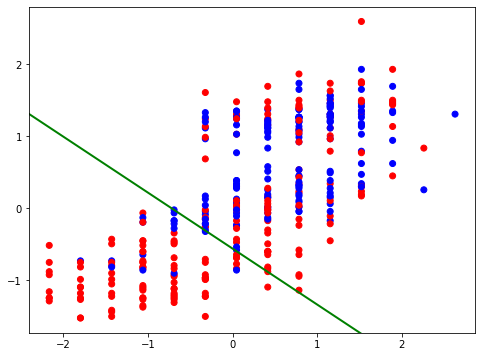

In [820]:
plot_separator_on_data(X2d_val, y_val, model.named_steps["logregr"])

In [821]:
model.score(X2d_val, y_val)

0.7884615384615384

In [822]:
f1_score(y_val, model.predict(X2d_val), average="macro")

0.788447168401428

In [823]:
precision_score(y_val, model.predict(X2d_val), average="macro")

0.7962793394988249

In [824]:
recall_score(y_val, model.predict(X2d_val), average="macro")

0.7953328465376658

In [825]:
pd.DataFrame(confusion_matrix(y_val, model.predict(X2d_val)), index=model.classes_, columns=model.classes_)

,No,Yes
No,142,56
Yes,21,145


##### AllKNN

In [826]:
from imblearn.under_sampling import AllKNN
X_under_sampled, y_under_sampled = AllKNN().fit_resample(X2d_processed, y)
X2d_train, X2d_val, y_train, y_val = train_test_split(
    X_under_sampled, y_under_sampled,           # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

In [827]:
model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("logregr", LogisticRegression(solver="saga", random_state=42, C=1000, penalty="elasticnet", l1_ratio=0))
])

In [828]:
model.fit(X2d_train, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


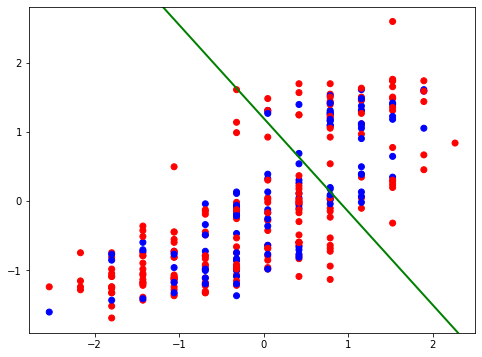

In [829]:
plot_separator_on_data(X2d_val, y_val, model.named_steps["logregr"])

In [830]:
model.score(X2d_val, y_val)

0.7625418060200669

In [831]:
f1_score(y_val, model.predict(X2d_val), average="macro")

0.7364984794886116

In [832]:
precision_score(y_val, model.predict(X2d_val), average="macro")

0.7438756762274166

In [833]:
recall_score(y_val, model.predict(X2d_val), average="macro")

0.7316511537715726

In [834]:
pd.DataFrame(confusion_matrix(y_val, model.predict(X2d_val)), index=model.classes_, columns=model.classes_)

,No,Yes
No,161,30
Yes,41,67


In [835]:
best_models.append((model, X2d_val, y_val))

##### One Sided Selection

In [836]:
from imblearn.under_sampling import OneSidedSelection
X_under_sampled, y_under_sampled = OneSidedSelection(random_state=42).fit_resample(X2d_processed, y)
X2d_train, X2d_val, y_train, y_val = train_test_split(
    X_under_sampled, y_under_sampled,           # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

In [837]:
model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("logregr", LogisticRegression(solver="saga", random_state=42, C=1000, penalty="elasticnet", l1_ratio=0))
])

In [838]:
model.fit(X2d_train, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


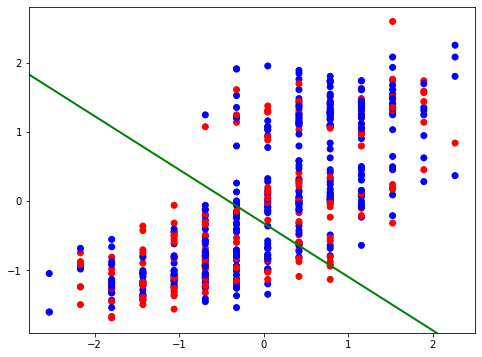

In [839]:
plot_separator_on_data(X2d_val, y_val, model.named_steps["logregr"])

In [840]:
model.score(X2d_val, y_val)

0.7234848484848485

In [841]:
f1_score(y_val, model.predict(X2d_val), average="macro")

0.6614611695680432

In [842]:
precision_score(y_val, model.predict(X2d_val), average="macro")

0.7158597446367231

In [843]:
recall_score(y_val, model.predict(X2d_val), average="macro")

0.6552270573430484

In [844]:
pd.DataFrame(confusion_matrix(y_val, model.predict(X2d_val)), index=model.classes_, columns=model.classes_)

,No,Yes
No,78,113
Yes,33,304


### SVM
Ora che abbiamo trovato le tecniche migliori di bilanciamento classi (`SVMSMOTE` e `AllKNN`) possiamo procedere cambiando l'algoritmo alla base del nostro modello, scegliamo infatti **SVM** che utilizza i support vectors; i quali sono definiti "*punti difficili*", poichè sono i più prossimi al decision boundary. </br> **SVM** ci permette di individuare la separazione lineare ottimale tra le istanze delle due classi, secondo un criterio geometrico.

##### SMOTE + SVM
Proviamo ad implementare un algoritmo SVM che sfrutti il metodo di resampling delle classi del dataset migliore fino ad ora, ossia l'`SVMSMOTE`.

In [845]:
from sklearn.svm import SVC

In [846]:
svm_smote = SVMSMOTE(random_state=42)
X_over_sampled, y_over_sampled = svm_smote.fit_resample(X2d_processed, y)
X2d_train_balanced, X2d_val_balanced, y_train_balanced, y_val_balanced = train_test_split(
    X_over_sampled, y_over_sampled,           # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

In [847]:
model = SVC(decision_function_shape='ovo', kernel="rbf", C=100, gamma=1.4, random_state=42)
model.fit(X2d_train_balanced, y_train_balanced);

In [848]:
grid = {
    "C": [1, 10, 100],
    "gamma": [1, 1.4, 10, 100]
}

In [849]:
gs = GridSearchCV(model, grid, cv=skf, scoring=make_scorer(f1_score, average="macro"))
gs.fit(X2d_train_balanced, y_train_balanced);

In [850]:
gs.best_params_

{'C': 10, 'gamma': 1.4}

In [851]:
gscv_results = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")
gscv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,0.177122,0.005710,0.116710,0.001208,10,1.4,"{'C': 10, 'gamma': 1.4}",0.804930,0.825497,0.789691,0.806706,0.014671,1
9,0.178909,0.008603,0.119229,0.001961,100,1.4,"{'C': 100, 'gamma': 1.4}",0.804930,0.825497,0.789691,0.806706,0.014671,1
1,0.176647,0.008126,0.121166,0.002992,1,1.4,"{'C': 1, 'gamma': 1.4}",0.802325,0.820764,0.780839,0.801309,0.016315,3
0,0.188881,0.017459,0.128275,0.009941,1,1,"{'C': 1, 'gamma': 1}",0.815023,0.824740,0.763715,0.801159,0.026772,4
4,0.171028,0.003089,0.119709,0.001312,10,1,"{'C': 10, 'gamma': 1}",0.814400,0.805154,0.759479,0.793011,0.024009,5
8,0.170279,0.002525,0.117219,0.003145,100,1,"{'C': 100, 'gamma': 1}",0.814400,0.805154,0.759479,0.793011,0.024009,5
6,0.179176,0.004770,0.123015,0.001104,10,10,"{'C': 10, 'gamma': 10}",0.670916,0.672594,0.652585,0.665365,0.009063,7
10,0.185030,0.002662,0.138255,0.006771,100,10,"{'C': 100, 'gamma': 10}",0.670916,0.672594,0.652585,0.665365,0.009063,7
2,0.182494,0.006166,0.132654,0.005291,1,10,"{'C': 1, 'gamma': 10}",0.648399,0.660155,0.634592,0.647715,0.010447,9
7,0.171090,0.001678,0.120633,0.000963,10,100,"{'C': 10, 'gamma': 100}",0.484916,0.530470,0.482948,0.499445,0.021953,10


In [852]:
f1_score(y_val_balanced, gs.best_estimator_.predict(X2d_val_balanced), average="macro")

0.8468744258078064

In [853]:
precision_score(y_val_balanced, gs.best_estimator_.predict(X2d_val_balanced), average="macro")

0.8818848417592606

In [854]:
recall_score(y_val_balanced, gs.best_estimator_.predict(X2d_val_balanced), average="macro")

0.8477626832450686

In [855]:
pd.DataFrame(confusion_matrix(y_val_balanced, gs.best_estimator_.predict(X2d_val_balanced)), index=gs.best_estimator_.classes_, columns=gs.best_estimator_.classes_)

,No,Yes
No,273,114
Yes,4,400


In [856]:
best_models.append((gs.best_estimator_, X2d_val_balanced, y_val_balanced))

#### AllKNN + SVM
Applichiamo lo stesso procedimento anche per l'algoritmo di **under-sampling** più promettente, ossia l'`ALLKNN`.

In [857]:
svm_allknn = AllKNN()
X_under_sampled, y_under_sampled = svm_allknn.fit_resample(X2d_processed, y)
X2d_train, X2d_val, y_train, y_val = train_test_split(
    X_under_sampled, y_under_sampled,           # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

In [858]:
model = SVC(decision_function_shape='ovo', kernel="rbf", C=100, gamma=1.4, random_state=42)
model.fit(X2d_train, y_train);

In [859]:
grid = {
    "C": [1, 10, 100],
    "gamma": [1, 1.4, 10, 100]
}

In [860]:
gs = GridSearchCV(model, grid, cv=skf, scoring=make_scorer(f1_score, average="macro"))
gs.fit(X2d_train, y_train);

In [861]:
gs.best_params_

{'C': 10, 'gamma': 1}

In [862]:
gscv_results = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")
gscv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,0.024010,0.000985,0.021377,0.002172,10,1,"{'C': 10, 'gamma': 1}",0.632166,0.578166,0.618774,0.609702,0.022960,1
8,0.023102,0.001422,0.019112,0.000867,100,1,"{'C': 100, 'gamma': 1}",0.632166,0.578166,0.618774,0.609702,0.022960,1
0,0.025924,0.003920,0.023626,0.006727,1,1,"{'C': 1, 'gamma': 1}",0.550320,0.543343,0.501886,0.531850,0.021378,3
5,0.025986,0.005124,0.020159,0.001385,10,1.4,"{'C': 10, 'gamma': 1.4}",0.422308,0.436345,0.411510,0.423388,0.010167,4
9,0.024201,0.001586,0.019122,0.000896,100,1.4,"{'C': 100, 'gamma': 1.4}",0.422308,0.436345,0.411510,0.423388,0.010167,4
1,0.024846,0.001364,0.019253,0.000123,1,1.4,"{'C': 1, 'gamma': 1.4}",0.371069,0.372240,0.372240,0.371850,0.000552,6
2,0.025154,0.001397,0.019384,0.000339,1,10,"{'C': 1, 'gamma': 10}",0.371069,0.372240,0.372240,0.371850,0.000552,6
3,0.024444,0.004350,0.020475,0.000225,1,100,"{'C': 1, 'gamma': 100}",0.371069,0.372240,0.372240,0.371850,0.000552,6
6,0.026706,0.002543,0.020732,0.000684,10,10,"{'C': 10, 'gamma': 10}",0.371069,0.372240,0.372240,0.371850,0.000552,6
7,0.022452,0.000793,0.019429,0.001115,10,100,"{'C': 10, 'gamma': 100}",0.371069,0.372240,0.372240,0.371850,0.000552,6


In [863]:
f1_score(y_val, gs.best_estimator_.predict(X2d_val), average="macro")

0.688198575310274

In [864]:
precision_score(y_val, gs.best_estimator_.predict(X2d_val), average="macro")

0.823665791776028

In [865]:
recall_score(y_val, gs.best_estimator_.predict(X2d_val), average="macro")

0.6793436106263331

In [866]:
pd.DataFrame(confusion_matrix(y_val, gs.best_estimator_.predict(X2d_val)), index=gs.best_estimator_.classes_, columns=gs.best_estimator_.classes_)

,No,Yes
No,187,4
Yes,67,41


- Dato il risultato di `f1_score` torniamo sui nostri passi e quindi sul modello di **Regressione Logistica** con metodo di **under-sampling** `AllKNN`.
- Tornando indietro nel notebook, in corrispondenza della descrizione di questo modello si troverà l'aggiunta alla lista `best_models` proprio per il motivo sopracitato.

### Modelli ad albero 
Osserviamo di seguito come i più noti algoritmi ad alberi di classificazione elaborano i nostri dati:

- Random Forest: algoritmo di tipo **bagging**, dove vengono creati numerosi alberi decisionali in parallelo, ognuno da un sottoinsieme del dataset di training in generale non disgiunto dagli altri.

In [867]:
from sklearn.ensemble import RandomForestClassifier

In [868]:
rfm = RandomForestClassifier(max_samples=0.9, n_estimators=200, max_depth=None, n_jobs=-1, random_state=42)

In [869]:
grid = {
    "max_samples": [0.3, 0.6, 0.9],
    "n_estimators": [200, 400, 600]
}

In [870]:
gs = GridSearchCV(rfm, grid, cv=skf, scoring=make_scorer(f1_score, average="macro"))

In [871]:
gs.fit(X2d_train_balanced, y_train_balanced)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(max_samples=0.9, n_estimators=200,
                                              n_jobs=-1, random_state=42),
             param_grid={'max_samples': [0.3, 0.6, 0.9],
                         'n_estimators': [200, 400, 600]},
             scoring=make_scorer(f1_score, average=macro))

In [872]:
gs.best_params_

{'max_samples': 0.9, 'n_estimators': 600}

In [873]:
gscv_results = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")
gscv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,2.561031,0.043949,0.309320,0.000533,0.9,600,"{'max_samples': 0.9, 'n_estimators': 600}",0.772289,0.793121,0.777960,0.781123,0.008794,1
7,1.660034,0.017347,0.207723,0.000317,0.9,400,"{'max_samples': 0.9, 'n_estimators': 400}",0.764664,0.795007,0.781733,0.780468,0.012419,2
6,0.954951,0.036933,0.141150,0.047886,0.9,200,"{'max_samples': 0.9, 'n_estimators': 200}",0.762754,0.796891,0.777909,0.779184,0.013966,3
5,2.371469,0.080484,0.309331,0.000324,0.6,600,"{'max_samples': 0.6, 'n_estimators': 600}",0.764664,0.793094,0.768480,0.775413,0.012599,4
3,0.873453,0.018816,0.175387,0.048056,0.6,200,"{'max_samples': 0.6, 'n_estimators': 200}",0.766590,0.787255,0.770369,0.774738,0.008984,5
4,2.040695,0.352022,0.278605,0.044696,0.6,400,"{'max_samples': 0.6, 'n_estimators': 400}",0.764664,0.787304,0.766573,0.772847,0.010252,6
0,1.272952,0.738845,0.108918,0.002213,0.3,200,"{'max_samples': 0.3, 'n_estimators': 200}",0.753313,0.756919,0.762778,0.757670,0.003900,7
1,1.534966,0.098027,0.276007,0.047484,0.3,400,"{'max_samples': 0.3, 'n_estimators': 400}",0.755204,0.745656,0.745722,0.748861,0.004485,8
2,2.083712,0.235900,0.345870,0.047651,0.3,600,"{'max_samples': 0.3, 'n_estimators': 600}",0.747624,0.749416,0.749517,0.748853,0.000870,9


In [874]:
model = gs.best_estimator_

In [876]:
f1_score(y_val_balanced, model.predict(X2d_val_balanced), average="macro")

0.7632498427448978

In [878]:
f1_score(y_val_balanced, model.predict(X2d_val_balanced), average=None)

array([0.7542707 , 0.77222899])

In [879]:
best_models.append((model, X2d_val_balanced, y_val_balanced))

- XGBoost: algoritmo che inizia con un modello a previsone costante, per poi sommare ad ogni iterazione un nuovo modello al precedente; dove ogni albero aggiunto è addestrato dal dataset degli errori residui del precedente.

In [ ]:
!pip install xgboost==1.1.0

In [880]:
from xgboost import XGBClassifier

In [881]:
xgbm = XGBClassifier(objective='binary:logistic', reg_alpha=0.5, reg_lambda=1.0, n_estimators=200, verbose_eval=True, random_state=42)

[19:19:49] WARNING: /workspace/src/learner.cc:480: 
Parameters: { verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0.5, reg_lambda=1.0, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbose_eval=True,
              verbosity=None)

In [908]:
grid = {
    "max_samples": [0.3, 0.6, 0.9],
    "n_estimators": [200, 400, 600],
    "reg_alpha": [0.5, 1, 1.5],
    "reg_lambda": [0.5, 1, 1.5]
}

In [915]:
gs = GridSearchCV(xgbm, grid, cv=skf, scoring=make_scorer(f1_score, average="macro"))

In [916]:
gs.fit(X2d_train_balanced, y_train_balanced)

[19:45:15] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_samples, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:45:16] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_samples, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:45:18] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_samples, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  ver

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_...
                                     n_estimators=200, n_jobs=0,
                                     num_parallel_tree=1, random_state=42,
                                     reg_alpha=0.5, reg_lambda=1.0,
                                     scale_pos_weight=1, subsample=1,
                                     tree_

In [918]:
gs.best_params_

{'max_samples': 0.3, 'n_estimators': 200, 'reg_alpha': 1.5, 'reg_lambda': 1.5}

In [919]:
gscv_results = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")
gscv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_samples,param_n_estimators,param_reg_alpha,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
80,2.460682,1.000236,0.012772,0.000112,0.9,600,1.5,1.5,"{'max_samples': 0.9, 'n_estimators': 600, 'reg...",0.760531,0.781755,0.756968,0.766418,0.010942,1
44,1.362865,0.020519,0.011978,0.000140,0.6,400,1.5,1.5,"{'max_samples': 0.6, 'n_estimators': 400, 'reg...",0.760531,0.781755,0.756968,0.766418,0.010942,1
17,1.355719,0.034591,0.012846,0.000378,0.3,400,1.5,1.5,"{'max_samples': 0.3, 'n_estimators': 400, 'reg...",0.760531,0.781755,0.756968,0.766418,0.010942,1
53,1.753472,0.008147,0.011992,0.000094,0.6,600,1.5,1.5,"{'max_samples': 0.6, 'n_estimators': 600, 'reg...",0.760531,0.781755,0.756968,0.766418,0.010942,1
62,0.926421,0.027201,0.012174,0.000223,0.9,200,1.5,1.5,"{'max_samples': 0.9, 'n_estimators': 200, 'reg...",0.760531,0.781755,0.756968,0.766418,0.010942,1
26,3.371899,2.100019,0.021365,0.011443,0.3,600,1.5,1.5,"{'max_samples': 0.3, 'n_estimators': 600, 'reg...",0.760531,0.781755,0.756968,0.766418,0.010942,1
35,0.928575,0.027347,0.012315,0.000187,0.6,200,1.5,1.5,"{'max_samples': 0.6, 'n_estimators': 200, 'reg...",0.760531,0.781755,0.756968,0.766418,0.010942,1
8,0.922488,0.014067,0.012144,0.000291,0.3,200,1.5,1.5,"{'max_samples': 0.3, 'n_estimators': 200, 'reg...",0.760531,0.781755,0.756968,0.766418,0.010942,1
71,1.338279,0.010936,0.012348,0.000459,0.9,400,1.5,1.5,"{'max_samples': 0.9, 'n_estimators': 400, 'reg...",0.760531,0.781755,0.756968,0.766418,0.010942,1
46,2.338519,0.038380,0.013477,0.000079,0.6,600,0.5,1,"{'max_samples': 0.6, 'n_estimators': 600, 'reg...",0.766331,0.783643,0.748866,0.766280,0.014198,10


In [920]:
model = gs.best_estimator_

In [922]:
f1_score(y_val_balanced, model.predict(X2d_val_balanced), average="macro")

0.7256619629617198

## 4) valutazione dei modelli di regressione, classificazione, recommendation con le metriche appropriate
 
- Visualizziamo ora i modelli migliori, collezionati mano a mano, analizzando varie statistiche tra cui anche la deviazione standard e lo scarto quadratico medio dell’errore dei relativi iperparametri ottenuto in k cross fold validation. 
- Valutiamo i modelli, calcolandone gli intervalli di confidenza predittivi fissata la confidenza del 95%.

In [889]:
best_models

[(Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                  ('logregr',
                   LogisticRegression(C=1000, l1_ratio=0, penalty='elasticnet',
                                      random_state=42, solver='saga'))]),
  array([[-0.32157703, -0.96508648, -0.62196154, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.04779911,  0.32194333, -0.40101375, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.04779911, -0.857834  , -0.5588336 , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.04779911,  0.02163637, -0.21162994, ...,  0.        ,
           0.        ,  0.        ],
         [-0.69095317, -1.20104195, -1.28480488, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.78655138,  1.15851271,  0.73528913, ...,  0.        ,
           0.        ,  0.        ]]),
  331     No
  638    Yes
  326     No
  847    Yes
  39      No
        ... 
  140     No
  173     No
  6 

In [890]:
from sklearn.model_selection import cross_val_score

- Calcoliamo lo **scarto quadratico medio** dei modelli migliori.

In [891]:
mean = [cross_val_score(m, X, y, cv=skf).mean() for m, X, y in best_models]
std = [cross_val_score(m, X, y, cv=skf).std() for m, X, y in best_models]
f1_scores = [f1_score(y, m.predict(X), average="macro") for m, X, y in best_models]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

In [892]:
pd.DataFrame(
    data={'Media': mean, 'Deviazione Standard': std, 'F1-Measure': f1_scores},
    index=['Logistic Regression+AllKNN', 'SVM+SVMSMOTE', 'Random Forest']
)

,Media,Deviazione Standard,F1-Measure
Logistic Regression+AllKNN,0.705758,0.015752,0.736498
SVM+SVMSMOTE,0.700402,0.018970,0.846874
Random Forest,0.711785,0.016777,0.763250


- Dal `DataFrame` osserviamo che i modelli da noi ritenuti migliori hanno una **deviazione standard** *piccola*, ciò indica che c'è una bassa variabilità degli score.
- Inoltre si aggirano intorno a una media di `0.7` circa.
- Calcoliamo ora l'*intervallo di confidenza* dei nostri modelli con **confidenza** del `95%`.

In [917]:
from scipy.stats import norm

In [894]:
def confidence_interval(a, N, Z=1.96):
  c = (2 * N * a + Z**2) / (2 * (N + Z**2))
  d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
  return c - d, c + d, 2*d

def model_confidence_interval(score, N, level=0.95):
  a = score
  Z = norm.ppf((1+level)/2)
  return confidence_interval(a, N, Z)

In [895]:
models_conf_intervals = [model_confidence_interval(f1_score[i], best_models[i][1].shape[0]) for i in range(len(best_models))]

In [896]:
models_conf_intervals

[(0.683792390990547, 0.7832047344523239, 0.09941234346177688),
 (0.8201072857330811, 0.8702886863669874, 0.050181400633906206),
 (0.7323982217597627, 0.7915568973407576, 0.05915867558099496)]

- Dal `DataFrame` seguente si evince che il miglior modello è quello che utilizza `SVMSMOTE` per fare **over-sampling** della classe minoritaria, nel nostro caso `No`(non-drafted), insieme all'algoritmo di classificazione `SVM`:

In [897]:
pd.DataFrame(
    data=models_conf_intervals,
    index=['Logistic Regression+AllKNN', 'SVM+SVMSMOTE', 'Random Forest'],
    columns=["Z(α/2)", "Z(1-(α/2))", "d"]
)

,Z(α/2),Z(1-(α/2)),d
Logistic Regression+AllKNN,0.683792,0.783205,0.099412
SVM+SVMSMOTE,0.820107,0.870289,0.050181
Random Forest,0.732398,0.791557,0.059159


- Notiamo infatti che il suddetto modello ha *range di score* nettamente *più alto* rispetto agli altri due che risiedono al di sotto dello `0.8`.
- Inoltre il modello con range di score più ampio è il primo con `d=0.099412`, quasi doppio degli altri.

### Modello migliore
Breve analisi dei coefficenti del modello migliore.

- Come visto in precedenza, il modello migliore è quello da noi "denominato" `SVM+SVMSMOTE`, inoltre si trova in posizione di indice `1` all'interno della lista `best_models`:

In [898]:
best_model = best_models[1][0]

In [899]:
best_model.intercept_

array([0.23278444])

In [938]:
best_model.dual_coef_.flatten()

array([-0.8567552 , -0.9252829 , -0.1865703 , ...,  0.82030812,
        0.76039662,  0.97243509])

- `dual_coef_` contiene i coefficenti relativi ai `support_vectors_`.
- Vediamo come sono organizzati:


In [935]:
best_model.support_vectors_

array([[-0.69095317, -0.8363835 , -0.68508947, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.6646205 ,  1.48110257,  1.44103435, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04779911,  1.32223245,  1.51278686, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.32157703, -0.53607654, -0.52726963, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04779911, -1.07233896, -1.37949679, ...,  0.        ,
         0.        ,  0.        ],
       [-0.32157703, -1.09378946, -0.62196154, ...,  0.        ,
         0.        ,  1.        ]])